### imports

In [2]:
!pip install tensorflow
!pip install gensim
!pip install tf-keras

In [42]:
import tensorflow as tf

from gensim.models import Word2Vec
from gensim.models import LsiModel
import gensim

import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sentence_transformers import SentenceTransformer
import json
import contractions
import random

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score



### prepare dataset

In [79]:

def pad_sequence(dataset, max_len=None):
    if not max_len:
        max_len = len(max(dataset, key=len))
    print("max length of MWO:", max_len)
    for i in range(len(dataset)):
        count = 0
        while len(dataset[i]) < max_len:
            dataset[i].append(dataset[i][count])
            count+=1
    return dataset

def add_inherent_functions(row):
    for e in row["entities"]:
        tokens = row["tokens"]
        entity_type = e["type"].split("/")
        if entity_type[0] == "PhysicalObject":
            if len(entity_type) > 1 and entity_type[1] not in ["Substance", "Organism"]:
                if entity_type[1][:-6].lower() not in tokens:
                    tokens.append(entity_type[1][:-6].lower())
                # tokens.append(entity_type[1][-6:].lower())
    return tokens

    # BROKEN CODE
    # physical_object_indices = []
    # 
    # for e in row["entities"]:
    #     new_list = row["tokens"]
    #     entity_type = e["type"].split("/")
    #     if entity_type[0] == "PhysicalObject":
    #         if len(entity_type) > 1 and entity_type[1] not in ["Substance", "Organism"]:
    #             new_string = " ".join(new_list)
    #             if e["end"] == len(row["tokens"]):
    #                 replace_index = new_string.find(" ".join(row["tokens"][e["start"]:]))
    #                 new_string = new_string.replace(" ".join(row["tokens"][e["start"]:]))
    #             else:
    #                 replace_index = new_string.find(" ".join(row["tokens"][e["start"]:e["end"]]))
    #                 new_string = new_string.replace(" ".join(row["tokens"][e["start"]:e["end"]]), "")
    #             new_string = new_string[replace_index:]
    #             new_list = new_string.split()
    #             physical_object_indices.append((e["start"], e["end"], entity_type[1]))
    # for i in physical_object_indices:
    #     if i[1] == len(row["tokens"]):
    #         row["tokens"].append(i[2])
        

def clean_tokens(tokens):
    stopwords =["<num>", "<id>", "-", "/", "and"]
    tokens = [i for i in tokens if i not in stopwords]
    tokens = contractions.fix(" ".join(tokens)).split()
    return tokens

def prepare_dataset(filename):
    f = open(filename, "r")
    # returns JSON object as a dictionary
    data = json.load(f)

    dataset = []

    for datum in data:
        keep_indices = []
        for entity in datum["entities"]:
            if entity["type"].split("/")[0] not in ["PhysicalObject", "Activity"]:
                start = entity["start"]
                end = entity["end"]
                for i in range(start, end):
                    keep_indices.append(i)

        tokens = []
        for i in sorted(set(keep_indices)):
            tokens.append(datum["tokens"][i])
        
        tokens = clean_tokens(tokens)
        if tokens:
            dataset.append(" ".join(tokens))
    # dataset = pad_sequence(dataset)
    return dataset

def full_dataset(filename):
    f = open(filename, "r")
    # returns JSON object as a dictionary
    data = json.load(f)

    d = []

    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
            tokens = clean_tokens(datum["tokens"])
            # d.append(" ".join(tokens))
            d.append(tokens)
    # d = pad_sequence(dataset)
    return d

def full_dataset_append_inherent_functions(filename):
    f = open(filename, "r")
    # returns JSON object as a dictionary
    data = json.load(f)

    d = []

    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
            tokens = add_inherent_functions(datum)
            tokens = clean_tokens(tokens)
            # d.append(" ".join(tokens))
            d.append(tokens)
    return d

# OG dataset

## CNN

In [64]:
dataset = full_dataset("../data/gold_release.json")
print(dataset)
# pad_sequence(dataset)
print(len(dataset))

[['air', 'conditioner', 'thermostat', 'not', 'working'], ['air', 'conditioner', 'thermostat', 'unserviceable'], ['air', 'conditioner', 'unserviceable'], ['air', 'conditioner', 'unserviceable', 'when', 'stationary'], ['air', 'conditioner', 'warm'], ['air', 'filters', 'plugged'], ['air', 'horn', 'disconnected'], ['air', 'horn', 'does', 'not', 'work'], ['air', 'horn', 'fault'], ['air', 'horn', 'not', 'working'], ['air', 'horn', 'not', 'working', 'compressor', 'awaiting'], ['air', 'horn', 'stuck', 'on'], ['air', 'horn', 'unserviceable'], ['air', 'horn', 'working', 'intermittently'], ['air', 'leak'], ['air', 'leak', 'near', 'side', 'of', 'door'], ['air', 'leaking', 'from', 'line', 'outside'], ['airhorn', 'not', 'working'], ['alarm', 'on', 'VIMS', 'does', 'not', 'work'], ['all', 'dash', 'lights', 'on'], ['alternator', 'drive', 'leaking'], ['alternator', 'failed'], ['alternator', 'not', 'charging'], ['alternator', 'overcharge', 'fault'], ['alternator', 'overcharged'], ['analyse', 'failed', 'd

In [65]:
# SBERT embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")
SBERT_embeddings = model.encode(dataset)
print(SBERT_embeddings.shape)

/opt/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(540, 384)


In [7]:
# Word2Vec embeddings as input
w2vmodel = gensim.models.Word2Vec(dataset, min_count=1, vector_size=100,
                                window=5, sg=1)
w2v_embeddings = []
for sentence in dataset:
    row = []
    for word in sentence:
        row.append(w2vmodel.wv[word])
    w2v_embeddings.append(row)
w2v_embeddings = np.array(w2v_embeddings)

In [8]:
print(w2v_embeddings.shape)
shape = w2v_embeddings.shape
w2v_embeddings=w2v_embeddings.reshape(shape[0], shape[1], shape[2], 1)
print(w2v_embeddings.shape)


(540, 11, 100)
(540, 11, 100, 1)


In [66]:
# LSI embeddings as output
dictionary = gensim.corpora.Dictionary(dataset)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in dataset]
lsamodel = LsiModel(doc_term_matrix, num_topics=10, id2word = dictionary)  # train model
concepts = list(lsamodel[doc_term_matrix])
lsa_embeddings=[]
for i in concepts:
    row = []
    for j in i:
        row.append(j[1])
    lsa_embeddings.append(row)
lsa_embeddings = np.array(lsa_embeddings)

In [67]:
print(lsa_embeddings.shape)
print(lsa_embeddings)

(540, 10)
[[-0.47431653 -1.2782885  -0.91834234 ... -0.61034892 -0.32856104
   0.15590842]
 [-0.54008579 -1.05384326 -0.7979275  ...  0.44503969  0.30655522
   0.128419  ]
 [-0.53286493 -1.02983923 -0.7778401  ...  0.44813846  0.30696067
   0.1225257 ]
 ...
 [-0.24101968 -0.27974647 -0.30957513 ...  0.20217668 -0.01385001
   0.39493835]
 [-0.21375224 -0.21440266  0.45153458 ...  0.02019542 -0.16308668
  -0.03343942]
 [-0.17558381 -0.10463617 -0.14563296 ...  0.53721338  0.25043225
   0.23397677]]


In [68]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation="relu", input_shape=(384,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=10, activation="tanh"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=10, activation="tanh")
])


In [69]:
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_16 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_33 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_17 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_18 (Ba  (None, 64)               

In [70]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model1.compile(optimizer=opt,
              loss=tf.keras.losses.MeanSquaredLogarithmicError("sum_over_batch_size"),
              metrics=['accuracy'])

history = model1.fit(SBERT_embeddings, lsa_embeddings, epochs=200)

Epoch 1/200
17/17 [==============================] - 1s 2ms/step - loss: 0.0885 - accuracy: 0.1574
Epoch 2/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.2130
Epoch 3/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0509 - accuracy: 0.2556
Epoch 4/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0415 - accuracy: 0.2833
Epoch 5/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 0.2981
Epoch 6/200
17/17 [==============================] - 0s 1ms/step - loss: 0.0262 - accuracy: 0.3352
Epoch 7/200
17/17 [==============================] - 0s 1ms/step - loss: 0.0223 - accuracy: 0.3685
Epoch 8/200
17/17 [==============================] - 0s 1ms/step - loss: 0.0194 - accuracy: 0.4148
Epoch 9/200
17/17 [==============================] - 0s 1ms/step - loss: 0.0173 - accuracy: 0.4167
Epoch 10/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.4537
Epoch 11/

[0.15740740299224854, 0.21296297013759613, 0.25555557012557983, 0.28333333134651184, 0.29814815521240234, 0.3351851999759674, 0.36851853132247925, 0.4148148000240326, 0.4166666567325592, 0.45370370149612427, 0.4574074149131775, 0.5277777910232544, 0.5111111402511597, 0.5166666507720947, 0.5240740776062012, 0.5592592358589172, 0.5407407283782959, 0.5388888716697693, 0.5648148059844971, 0.5611110925674438, 0.5388888716697693, 0.5925925970077515, 0.5759259462356567, 0.6000000238418579, 0.6000000238418579, 0.6111111044883728, 0.6277777552604675, 0.6259258985519409, 0.6277777552604675, 0.6092592477798462, 0.5907407402992249, 0.6074073910713196, 0.6018518805503845, 0.6129629611968994, 0.6037036776542664, 0.605555534362793, 0.5870370268821716, 0.6092592477798462, 0.6166666746139526, 0.6185185313224792, 0.6203703880310059, 0.6259258985519409, 0.6388888955116272, 0.6388888955116272, 0.6333333253860474, 0.6296296119689941, 0.6296296119689941, 0.6203703880310059, 0.6296296119689941, 0.63888889551

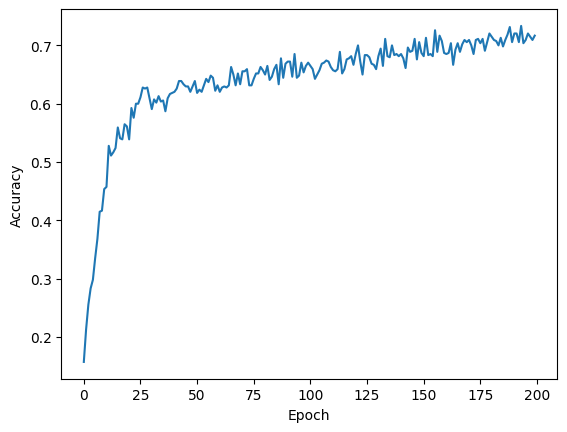

In [72]:
acc = history.history['accuracy']
print(acc)
plt.plot(acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')
plt.show()

In [73]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation="relu", input_shape=(384,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=10, activation="tanh")
])

model2.layers[0].set_weights(model1.layers[0].get_weights())
model2.layers[2].set_weights(model1.layers[2].get_weights())
model2.layers[4].set_weights(model1.layers[4].get_weights())
model2.layers[6].set_weights(model1.layers[6].get_weights())

In [74]:
cluster_embeddings = model2.predict(SBERT_embeddings)
print(cluster_embeddings.shape)

17/17 [==============================] - 0s 657us/step
(540, 10)


### k means + plotting cluster embeddings

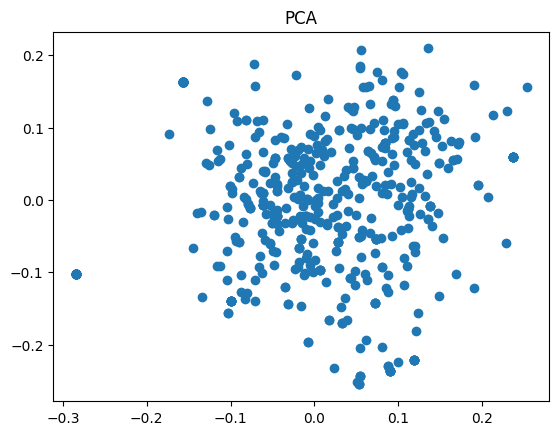

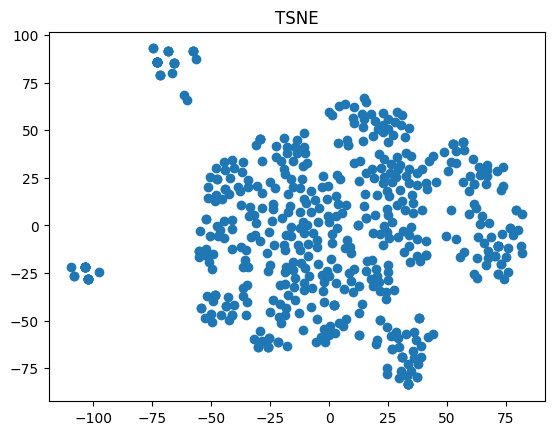

In [75]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score


# PCA reduction
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(cluster_embeddings)
plt.scatter(pca_embedding[:,0], pca_embedding[:,1])
plt.title("PCA")
plt.show()

# tsne reduction
tsne = TSNE(n_components=2).fit_transform(cluster_embeddings)
plt.scatter(tsne[:,0], tsne[:,1])
plt.title("TSNE")
plt.show()


# # Perform kmean clustering
# silhouette_scores = []
# test_k = list(range(5, 105, 5))
# for i in test_k:
#     print(i, "/", 100)
#     kmeans = KMeans(n_clusters=i, random_state=42, n_init=100).fit(cluster_embeddings)
#     labels = kmeans.labels_
#     silhouette_scores.append(silhouette_score(cluster_embeddings, labels))
# plt.plot(test_k, silhouette_scores)
# plt.title("Silhouette Scores")
# plt.show()

In [76]:
dataset_not_padded = full_dataset("../data/gold_release.json")
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=42, n_init=100).fit(pca_embedding)
labels = kmeans.labels_
for i in range(15):
    print("Cluster ", i)
    for j in range(len(labels)):
        if labels[j] == i:
            print(dataset_not_padded[j])

Cluster  0
['change', 'out', 'blown', 'o-ring', 'on', 'steering', 'pump']
['change', 'out', 'blown', 'position', 'tyre']
['change', 'out', 'blown', 'steering', 'hose']
['change', 'out', 'broken', 'bolt', 'on', 'brake', 'pump']
['change', 'out', 'broken', 'prelube', 'bracket']
['change', 'out', 'broken', 'stabilizer', 'bar']
['change', 'out', 'cracked', 'pipe', 'on', 'valve', 'bank']
['change', 'out', 'cracked', 'position', 'adaptor', 'and', 'tooth']
['change', 'out', 'exhaust', 'clamp', 'broken', 'on', 'left', 'hand', 'side', '[t', '|]']
['change', 'out', 'front', 'upper', 'window', 'cracked']
['change', 'out', 'leak', 'slew', 'motor', 'hose']
['change', 'out', 'leaking', 'HMU', 'on', 'next']
['change', 'out', 'leaking', 'fan', 'hoses']
['change', 'out', 'leaking', 'heater', 'taps']
['change', 'out', 'leaking', 'hydraulic', 'hose']
['change', 'out', 'leaking', 'implement', 'pump']
['change', 'out', 'leaking', 'relay', 'valve']
['change', 'out', 'leaking', 'steering', 'hose']
['change',

## Hierachical Clustering

### Average clustering

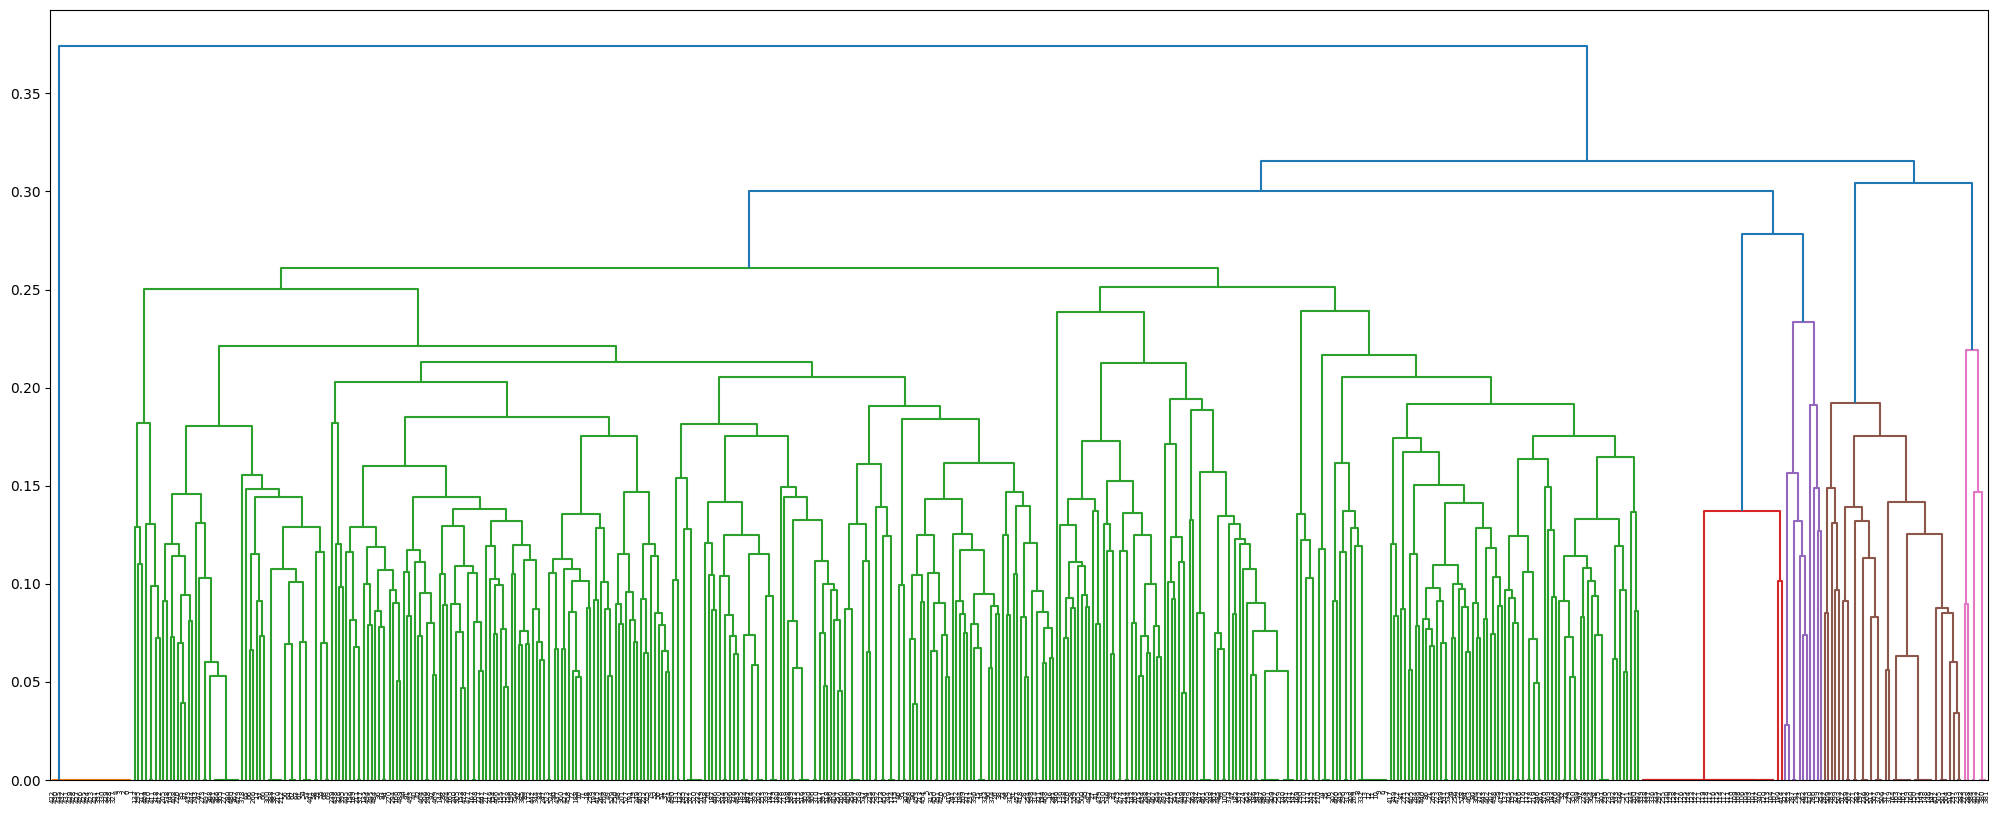

In [77]:
linkage_data = linkage(cluster_embeddings, method='average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_data)
plt.show()

In [78]:
k=8
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(" ".join(dataset_not_padded[j]))
            for word in dataset_not_padded[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
air conditioner thermostat not working
air conditioner thermostat unserviceable
air conditioner unserviceable
air conditioner unserviceable when stationary
air conditioner warm
air conditioner compressor corroded
air conditioner compressor unserviceable
air conditioner fault
air conditioner no good
air conditioner system leaking
air conditioner accessory drive leaking oil
air conditioner belt broken
air conditioner compressor not working
air conditioner compressor tripping out
air conditioner drive leaking
air conditioner drive leaking oil
air conditioner fan unserviceable fit new
air conditioner fault
air conditioner needs a boost not cold
air conditioner not cold PO
air conditioner not cold electrical faults
air conditioner pressure switch unserviceable
air conditioner fan speed resistor not working and
Top words:
air
conditioner
not
unserviceable
compressor

Cluster 2 :
air filters plugged
air leak
air leak near side of door
air leaking from line outside
airhorn not work

### ward clustering

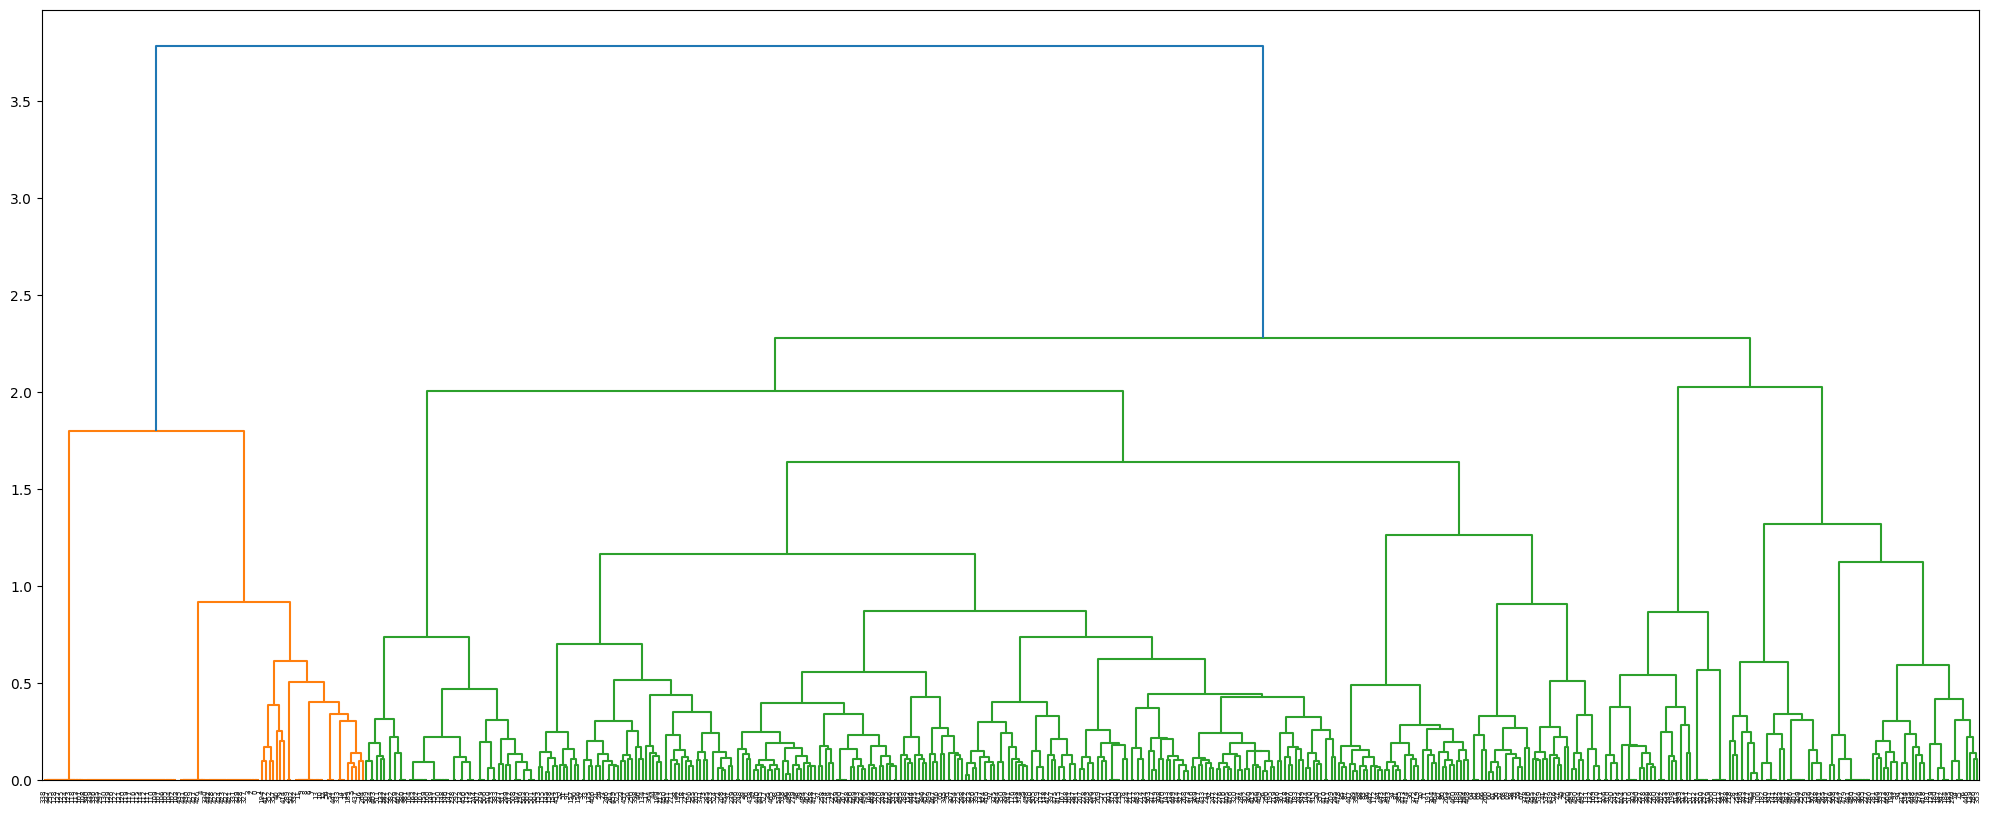

In [36]:
linkage_data = linkage(cluster_embeddings, method='ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_data)
plt.show()

In [37]:
k=7
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(" ".join(dataset_not_padded[j]))
            for word in dataset_not_padded[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
change out blown o-ring on steering pump
change out blown position tyre
change out blown steering hose
change out broken bolt on brake pump
change out broken prelube bracket
change out broken stabilizer bar
change out cracked pipe on valve bank
change out cracked position adaptor and tooth
change out exhaust clamp broken on left hand side [t |]
change out front upper window cracked
change out leak slew motor hose
change out leaking HMU on next
change out leaking fan hoses
change out leaking heater taps
change out leaking hydraulic hose
change out leaking implement pump
change out leaking relay valve
change out leaking steering hose
change out left hand steering cylinder leaking
change out position and tyre worn out
change out position tyre sensor not reading
change out position tyre damage
change out unserviceable jacket water pump
change out unserviceable left hand bucket cylinder hose
change out unserviceable position tyre
change out unserviceable right hand clam cylinder

### centroid clustering

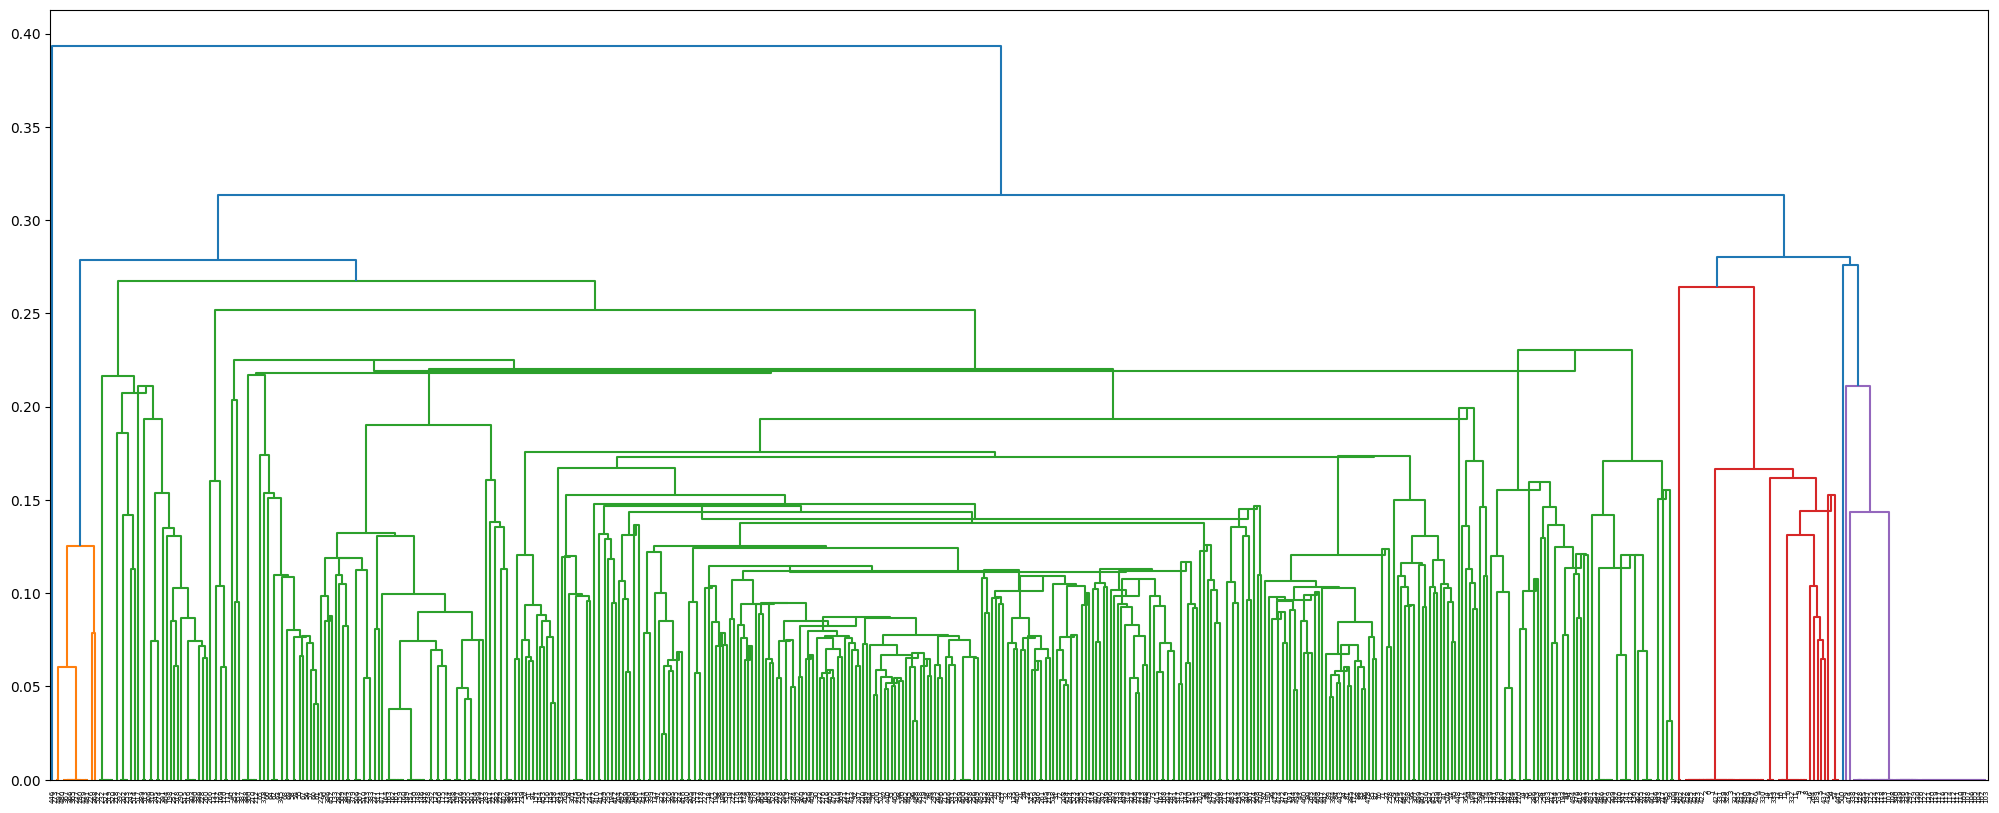

In [38]:
linkage_data = linkage(cluster_embeddings, method='centroid')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_data)
plt.show()

In [39]:
k=8
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(" ".join(dataset_not_padded[j]))
            for word in dataset_not_padded[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
front right hand roller need to be fitted
right hand bobbin roller unserviceable
left hand side pinion change out cover cracking
left hand rear brake cooling hose leaking
left hand boom cylinder hose leaking PO
left hand corner bonnet cracked
left hand side boom foot crack repair
lower left hand headlight blown
left hand chain guide unserviceable
left hand chain guide worn at the top
left hand PTO pump chip sensor harness unserviceable
right hand PTO cavity emptying
Top words:
hand
left
right
unserviceable
roller

Cluster 2 :
replace faulty brake sensor task
replace leaking transfer pipe
replace oil leaks
replace transmission cracked
replace unserviceable differential drain plugs
replace right hand lift cylinder leaking
replace damaged position tyre and position
replace leaking scavenge pump
replace missing cutting edge
replace x cracked windows
replace damaged tyre on position
replace damage auto-greaser door
replace cracked transmission dropbox
replace position tyre damag

# Inherent Function dataset

## CNN

In [79]:
dataset2 = full_dataset_append_inherent_functions("../data/gold_release.json")
print(dataset2)
# pad_sequence(dataset2)
print(len(dataset2))

[['air', 'conditioner', 'thermostat', 'not', 'working', 'emitting', 'sensing'], ['air', 'conditioner', 'thermostat', 'unserviceable', 'emitting', 'sensing'], ['air', 'conditioner', 'unserviceable', 'emitting'], ['air', 'conditioner', 'unserviceable', 'when', 'stationary', 'emitting'], ['air', 'conditioner', 'warm', 'emitting'], ['air', 'filters', 'plugged', 'matterprocessing'], ['air', 'horn', 'disconnected', 'presenting'], ['air', 'horn', 'does', 'not', 'work', 'presenting'], ['air', 'horn', 'fault', 'presenting'], ['air', 'horn', 'not', 'working', 'presenting'], ['air', 'horn', 'not', 'working', 'compressor', 'awaiting', 'presenting', 'generating'], ['air', 'horn', 'stuck', 'on', 'presenting'], ['air', 'horn', 'unserviceable', 'presenting'], ['air', 'horn', 'working', 'intermittently', 'presenting'], ['air', 'leak'], ['air', 'leak', 'near', 'side', 'of', 'door', 'controlling'], ['air', 'leaking', 'from', 'line', 'outside', 'guiding'], ['airhorn', 'not', 'working', 'presenting'], ['al

In [80]:
# SBERT embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")
SBERT_embeddings2 = model.encode(dataset2)
print(SBERT_embeddings2.shape)

/opt/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(540, 384)


In [47]:
# # Word2Vec embeddings as input
# w2vmodel2 = gensim.models.Word2Vec(dataset2, min_count=1, vector_size=100,
#                                 window=5, sg=1)
# w2v_embeddings2 = []
# for sentence in dataset2:
#     row = []
#     for word in sentence:
#         row.append(w2vmodel2.wv[word])
#     w2v_embeddings2.append(row)
# w2v_embeddings2 = np.array(w2v_embeddings2)

In [81]:
# print(w2v_embeddings2.shape)
# shape = w2v_embeddings2.shape
# w2v_embeddings2=w2v_embeddings2.reshape(shape[0], shape[1], shape[2], 1)
# print(w2v_embeddings2.shape)


In [82]:
# LSI embeddings as output
dictionary = gensim.corpora.Dictionary(dataset2)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in dataset2]
lsamodel2 = LsiModel(doc_term_matrix, num_topics=10, id2word = dictionary)  # train model
concepts = list(lsamodel2[doc_term_matrix])
lsa_embeddings2=[]
for i in concepts:
    row = []
    for j in i:
        row.append(j[1])
    lsa_embeddings2.append(row)
lsa_embeddings2 = np.array(lsa_embeddings2)

In [83]:
print(lsa_embeddings2.shape)
print(lsa_embeddings2)

(540, 10)
[[-0.64968048  0.95560484 -1.48770747 ...  0.02814566 -0.17423918
   0.43317416]
 [-0.69425419  0.87491569 -1.33235044 ...  0.04088295  0.00234487
   0.31310629]
 [-0.64068143  0.81189102 -1.25515632 ...  0.14251387  0.16536157
   0.24972655]
 ...
 [-0.22972407  0.22591919 -0.22538342 ...  0.09190645 -0.45596354
   0.10164684]
 [-0.35253077  0.21611752  0.48402525 ... -0.32991734  0.12723265
   0.00656433]
 [-0.37288439  0.56150173  0.26740807 ...  0.01095912 -0.00151993
  -0.00665223]]


In [87]:
# model3 = tf.keras.Sequential([
#     tf.keras.layers.Dense(units=128, activation="relu", input_shape=(384,)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(units=128, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(units=64, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(units=10, activation="tanh"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(units=10, activation="tanh")
# ])


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [84]:
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_16 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_33 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_17 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_18 (Ba  (None, 64)               

In [85]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model1.compile(optimizer=opt,
              loss=tf.keras.losses.MeanSquaredLogarithmicError("sum_over_batch_size"),
              metrics=['accuracy'])

history = model1.fit(SBERT_embeddings2, lsa_embeddings2, epochs=200)


Epoch 1/200
17/17 [==============================] - 1s 2ms/step - loss: 0.0475 - accuracy: 0.0667
Epoch 2/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0389 - accuracy: 0.1519
Epoch 3/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0357 - accuracy: 0.2148
Epoch 4/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.2296
Epoch 5/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.2926
Epoch 6/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0281 - accuracy: 0.3222
Epoch 7/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0263 - accuracy: 0.3833
Epoch 8/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0241 - accuracy: 0.4148
Epoch 9/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0229 - accuracy: 0.4426
Epoch 10/200
17/17 [==============================] - 0s 2ms/step - loss: 0.0220 - accuracy: 0.4759
Epoch 11/

[0.06666667014360428, 0.1518518477678299, 0.21481481194496155, 0.22962963581085205, 0.2925925850868225, 0.3222222328186035, 0.38333332538604736, 0.4148148000240326, 0.442592591047287, 0.47592592239379883, 0.4703703820705414, 0.47962963581085205, 0.5037037134170532, 0.5111111402511597, 0.5018518567085266, 0.5018518567085266, 0.5240740776062012, 0.5444444417953491, 0.5259259343147278, 0.5333333611488342, 0.550000011920929, 0.5462962985038757, 0.5518518686294556, 0.550000011920929, 0.5648148059844971, 0.5611110925674438, 0.550000011920929, 0.5703703761100769, 0.5703703761100769, 0.5833333134651184, 0.5611110925674438, 0.5518518686294556, 0.5722222328186035, 0.5944444537162781, 0.5981481671333313, 0.5814814567565918, 0.5888888835906982, 0.6000000238418579, 0.5981481671333313, 0.5796296000480652, 0.6000000238418579, 0.6111111044883728, 0.585185170173645, 0.5981481671333313, 0.5833333134651184, 0.5907407402992249, 0.605555534362793, 0.6185185313224792, 0.6314814686775208, 0.6314814686775208,

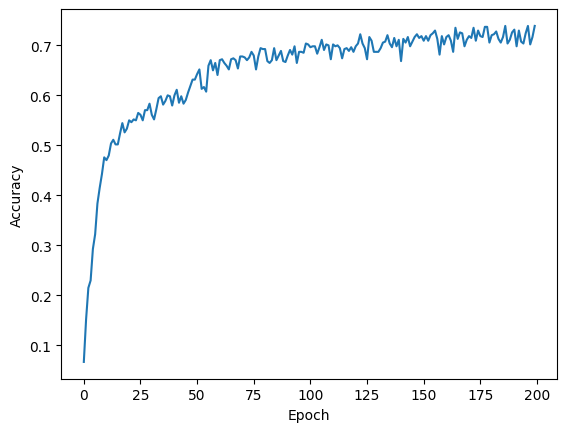

In [86]:
acc = history.history['accuracy']
print(acc)
plt.plot(acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')
plt.show()


In [88]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation="relu", input_shape=(384,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=10, activation="tanh")
])

model3.layers[0].set_weights(model1.layers[0].get_weights())
model3.layers[2].set_weights(model1.layers[2].get_weights())
model3.layers[4].set_weights(model1.layers[4].get_weights())
model3.layers[6].set_weights(model1.layers[6].get_weights())

In [89]:
cluster_embeddings = model3.predict(SBERT_embeddings)
print(cluster_embeddings.shape)

17/17 [==============================] - 0s 596us/step
(540, 10)


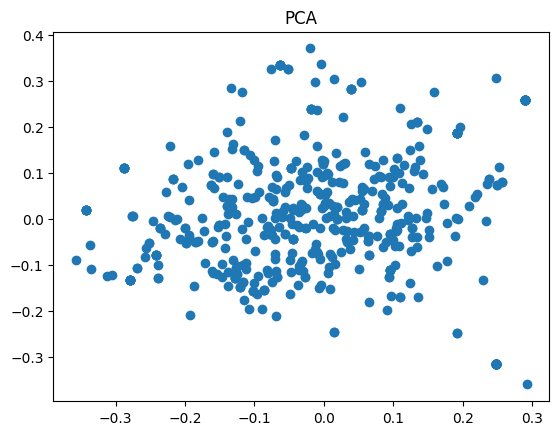

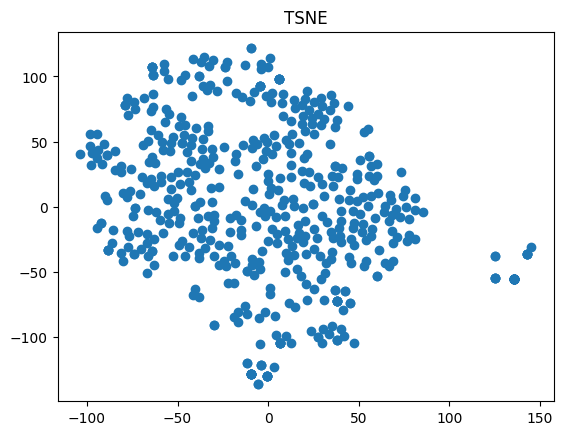

5 / 100
10 / 100
15 / 100
20 / 100
25 / 100
30 / 100
35 / 100
40 / 100
45 / 100
50 / 100
55 / 100
60 / 100
65 / 100
70 / 100
75 / 100
80 / 100
85 / 100
90 / 100
95 / 100
100 / 100


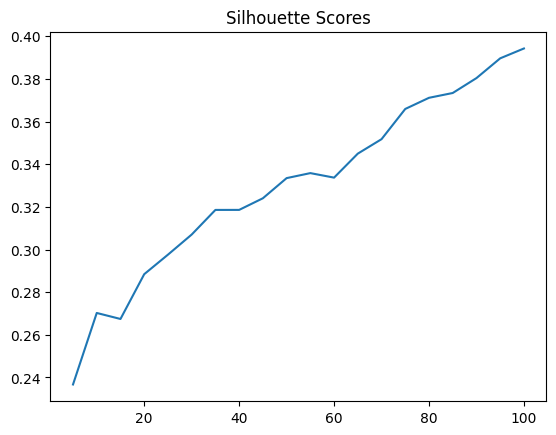

In [90]:
dataset_not_padded = full_dataset("../data/gold_release.json")

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score


# PCA reduction
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(cluster_embeddings)
plt.scatter(pca_embedding[:,0], pca_embedding[:,1])
plt.title("PCA")
plt.show()

# tsne reduction
tsne = TSNE(n_components=2).fit_transform(cluster_embeddings)
plt.scatter(tsne[:,0], tsne[:,1])
plt.title("TSNE")
plt.show()


# Perform kmean clustering
silhouette_scores = []
test_k = list(range(5, 105, 5))
for i in test_k:
    print(i, "/", 100)
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=100).fit(cluster_embeddings)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(cluster_embeddings, labels))
plt.plot(test_k, silhouette_scores)
plt.title("Silhouette Scores")
plt.show()


In [91]:
# best k
k = 20
kmeans = KMeans(n_clusters=k, random_state=42, n_init=100).fit(cluster_embeddings)

for i in range(k):
    print("Cluster ", i)
    for j in range(len(labels)):
        if labels[j] == i:
            print(dataset_not_padded[j])
            
    print()

Cluster  0
['armrest', 'unserviceable']
['both', 'stick', 'cylinders', 'leaking']
['cabin', 'jacking', 'cylinder', 'ends', 'unserviceable']
['stick', 'cylinder', 'leaking']
['stick', 'cracks']

Cluster  1
['damage', 'to', 'position', 'tyre']
['replace', 'damaged', 'position', 'tyre', 'and', 'position']
['tail', 'pulley', 'has', 'no', 'grease', 'lines']
['replace', 'damaged', 'tyre', 'on', 'position']
['exhaust', 'leak']

Cluster  2
['air', 'conditioner', 'thermostat', 'not', 'working']
['air', 'conditioner', 'thermostat', 'unserviceable']
['air', 'conditioner', 'unserviceable']
['air', 'conditioner', 'unserviceable', 'when', 'stationary']
['air', 'conditioner', 'warm']
['air', 'conditioner', 'compressor', 'corroded']
['air', 'conditioner', 'compressor', 'unserviceable']
['air', 'conditioner', 'fault']
['air', 'conditioner', 'no', 'good']
['air', 'conditioner', 'system', 'leaking']
['air', 'conditioner', 'accessory', 'drive', 'leaking', 'oil']
['air', 'conditioner', 'belt', 'broken']
['

## Hierachical Clustering

In [92]:
def silhouette(type, embeddings):
    silhouette_scores = []
    test_k = list(range(5, 105, 5))
    linkage_data = linkage(embeddings, method=type)
    for i in test_k:
        # print(i, "/", 100)
        cluster_labels = fcluster(linkage_data, i, criterion='maxclust')
        silhouette_scores.append(silhouette_score(embeddings, cluster_labels))
    plt.plot(test_k, silhouette_scores)
    plt.title("Silhouette Scores")
    plt.show()

### Average clustering

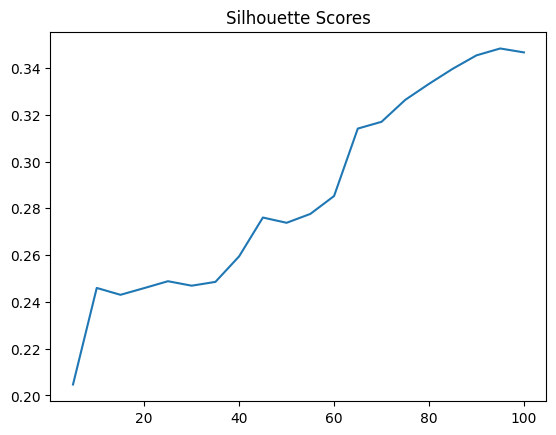

In [93]:
silhouette('average', cluster_embeddings)

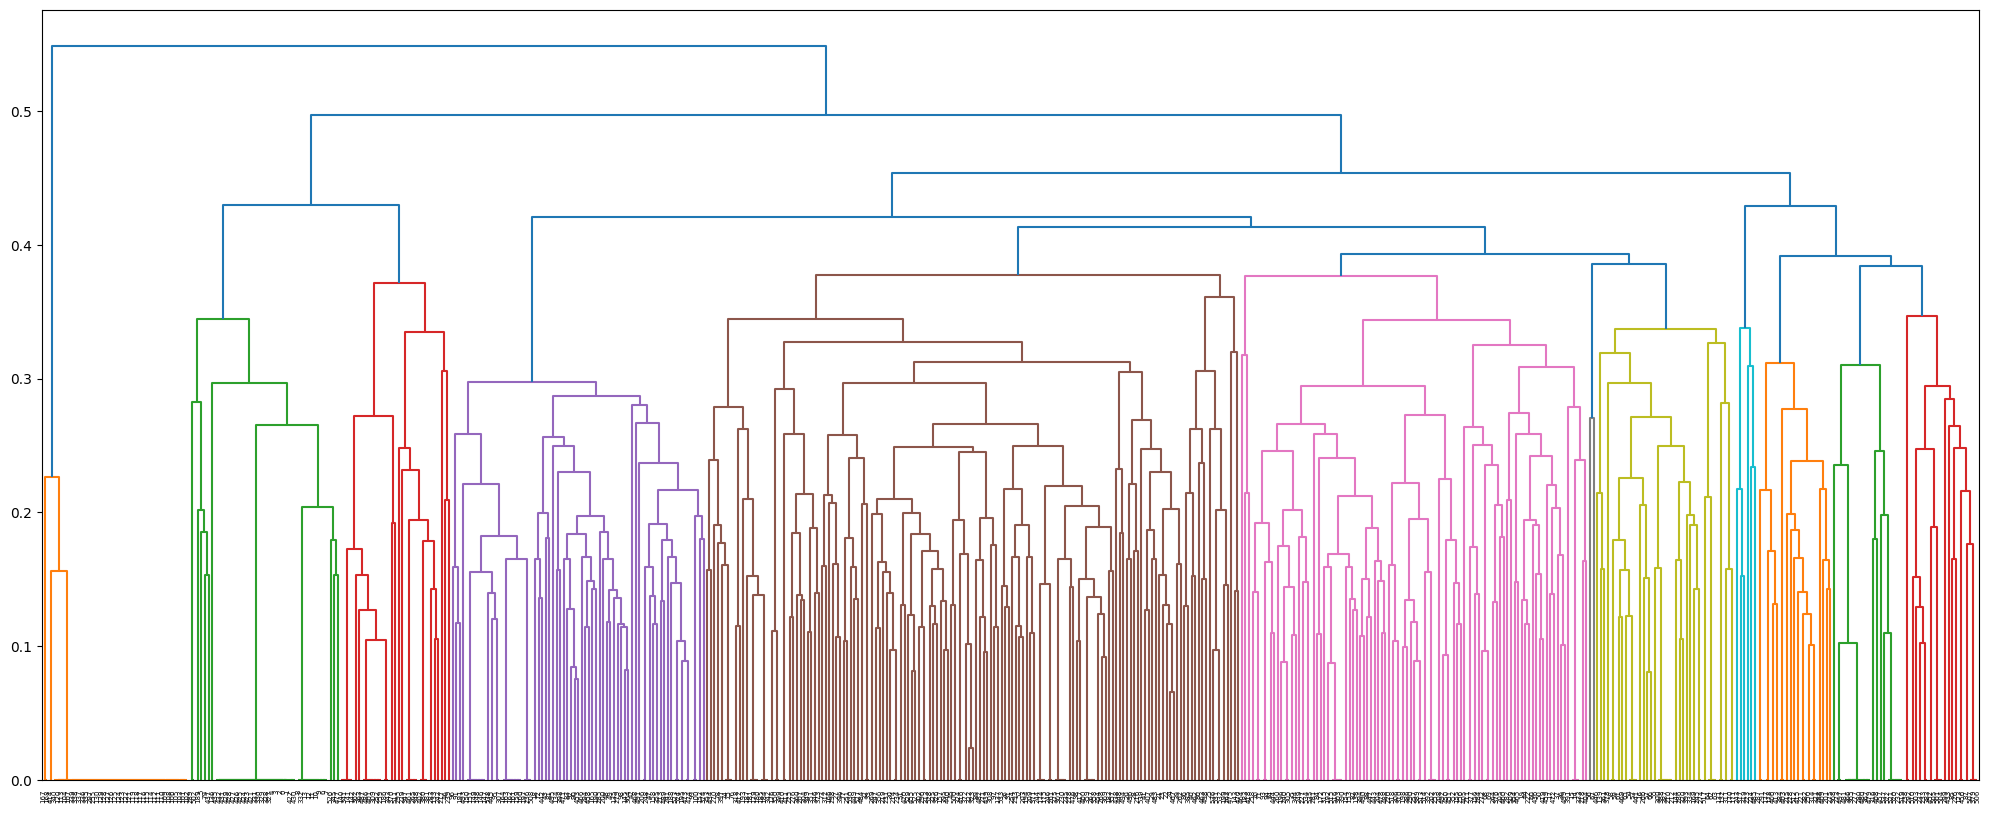

In [94]:
linkage_data = linkage(cluster_embeddings, method='average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_data)
plt.show()

In [95]:
k=12
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(" ".join(dataset2[j]))
            for word in set(dataset2[j]):
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
change out blown o-ring on steering pump generating covering controlling
change out blown position tyre guiding
change out blown steering hose guiding controlling
change out broken bolt on brake pump holding restricting generating
change out broken prelube bracket holding protecting
change out broken stabilizer bar holding
change out cracked pipe on valve bank guiding controlling
change out cracked position adaptor and tooth matterprocessing holding
change out exhaust clamp broken on left hand side [t |] guiding holding
change out front upper window cracked controlling
change out leak slew motor hose driving guiding
change out leaking HMU on next driving
change out leaking fan hoses generating guiding
change out leaking heater taps emitting controlling
change out leaking hydraulic hose guiding
change out leaking implement pump generating
change out leaking relay valve controlling
change out leaking steering hose guiding controlling
change out left hand steering cylinder lea

### ward clustering

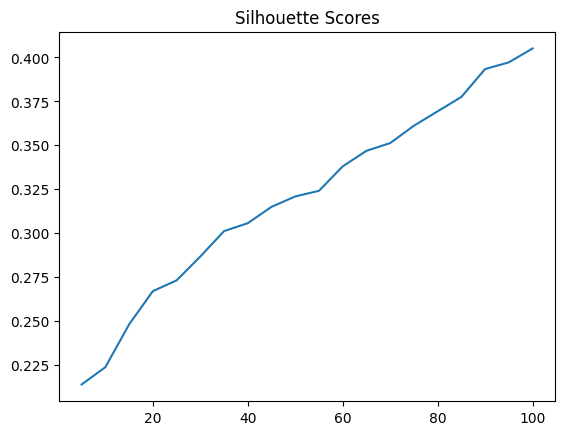

In [97]:
silhouette('ward', cluster_embeddings)

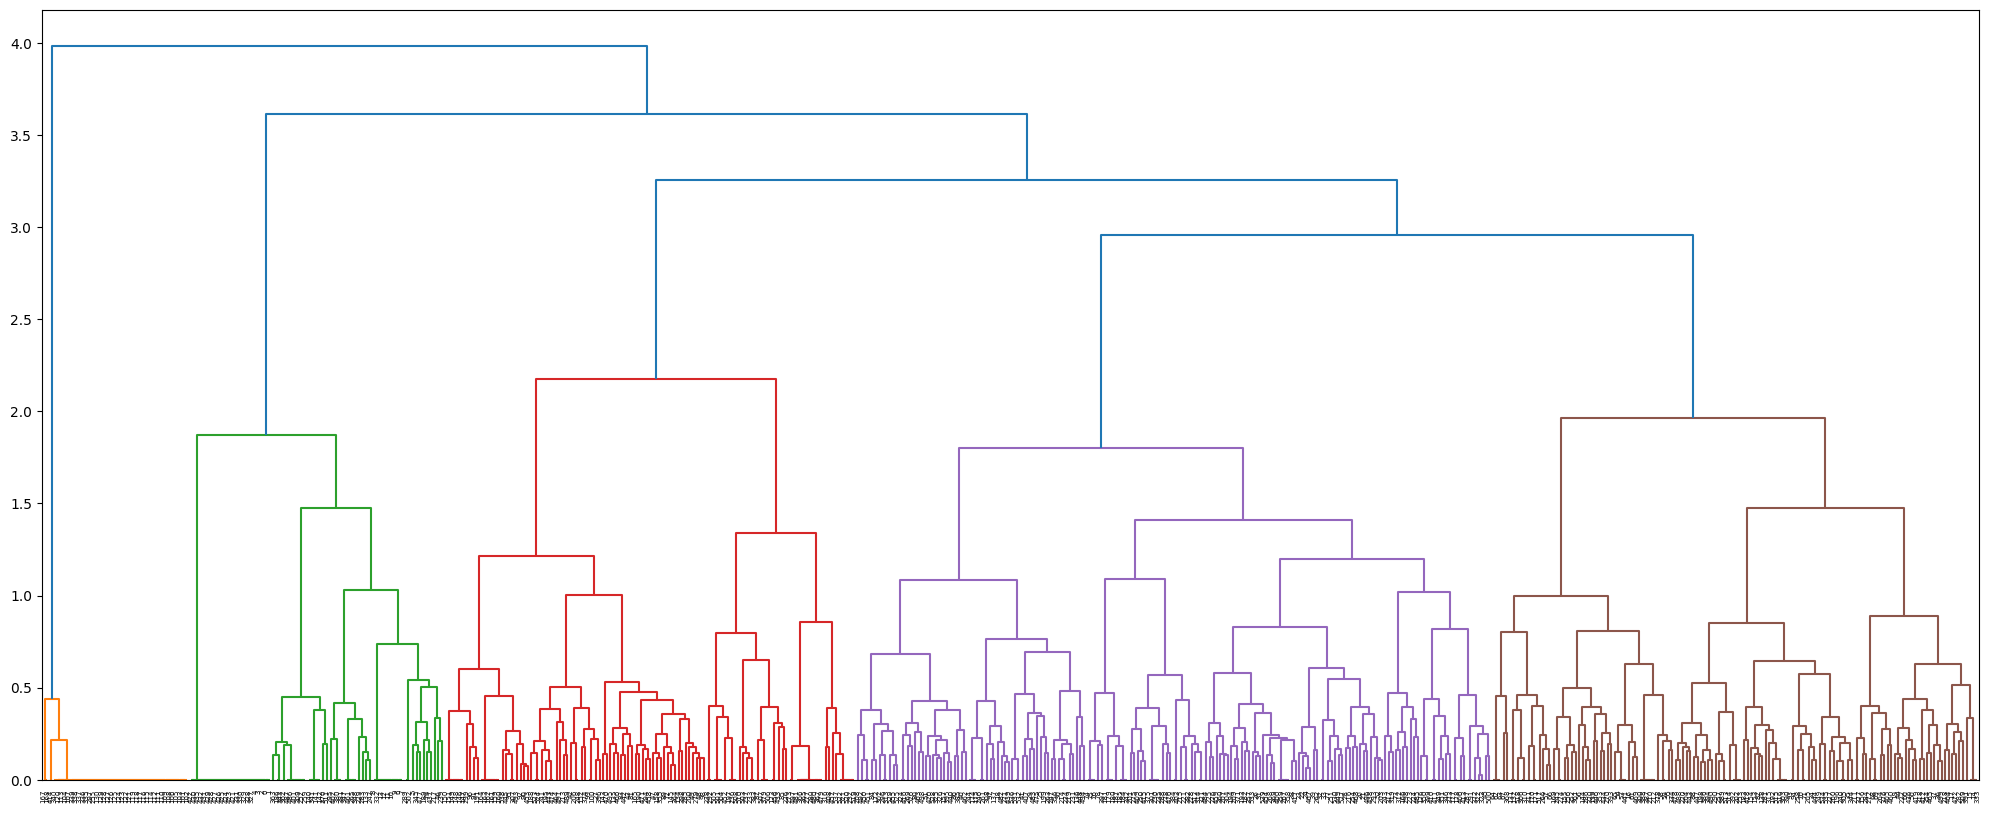

In [96]:
linkage_data = linkage(cluster_embeddings, method='ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_data)
plt.show()

In [98]:
k=13
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(" ".join(dataset_not_padded[j]))
            for word in dataset_not_padded[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
change out blown o-ring on steering pump
change out blown position tyre
change out blown steering hose
change out broken bolt on brake pump
change out broken prelube bracket
change out broken stabilizer bar
change out cracked pipe on valve bank
change out cracked position adaptor and tooth
change out exhaust clamp broken on left hand side [t |]
change out front upper window cracked
change out leak slew motor hose
change out leaking HMU on next
change out leaking fan hoses
change out leaking heater taps
change out leaking hydraulic hose
change out leaking implement pump
change out leaking relay valve
change out leaking steering hose
change out left hand steering cylinder leaking
change out position and tyre worn out
change out position tyre sensor not reading
change out position tyre damage
change out unserviceable jacket water pump
change out unserviceable left hand bucket cylinder hose
change out unserviceable position tyre
change out unserviceable right hand clam cylinder

### centroid clustering

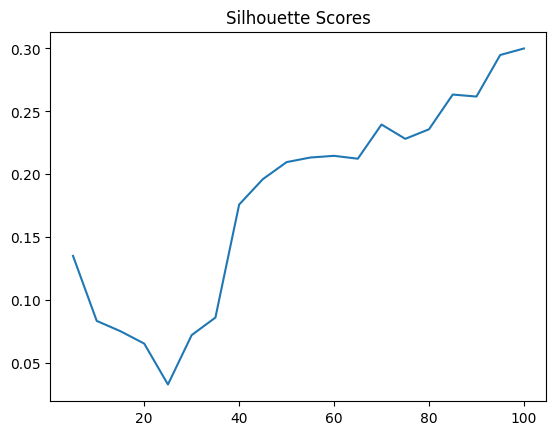

In [100]:
silhouette('centroid', cluster_embeddings)

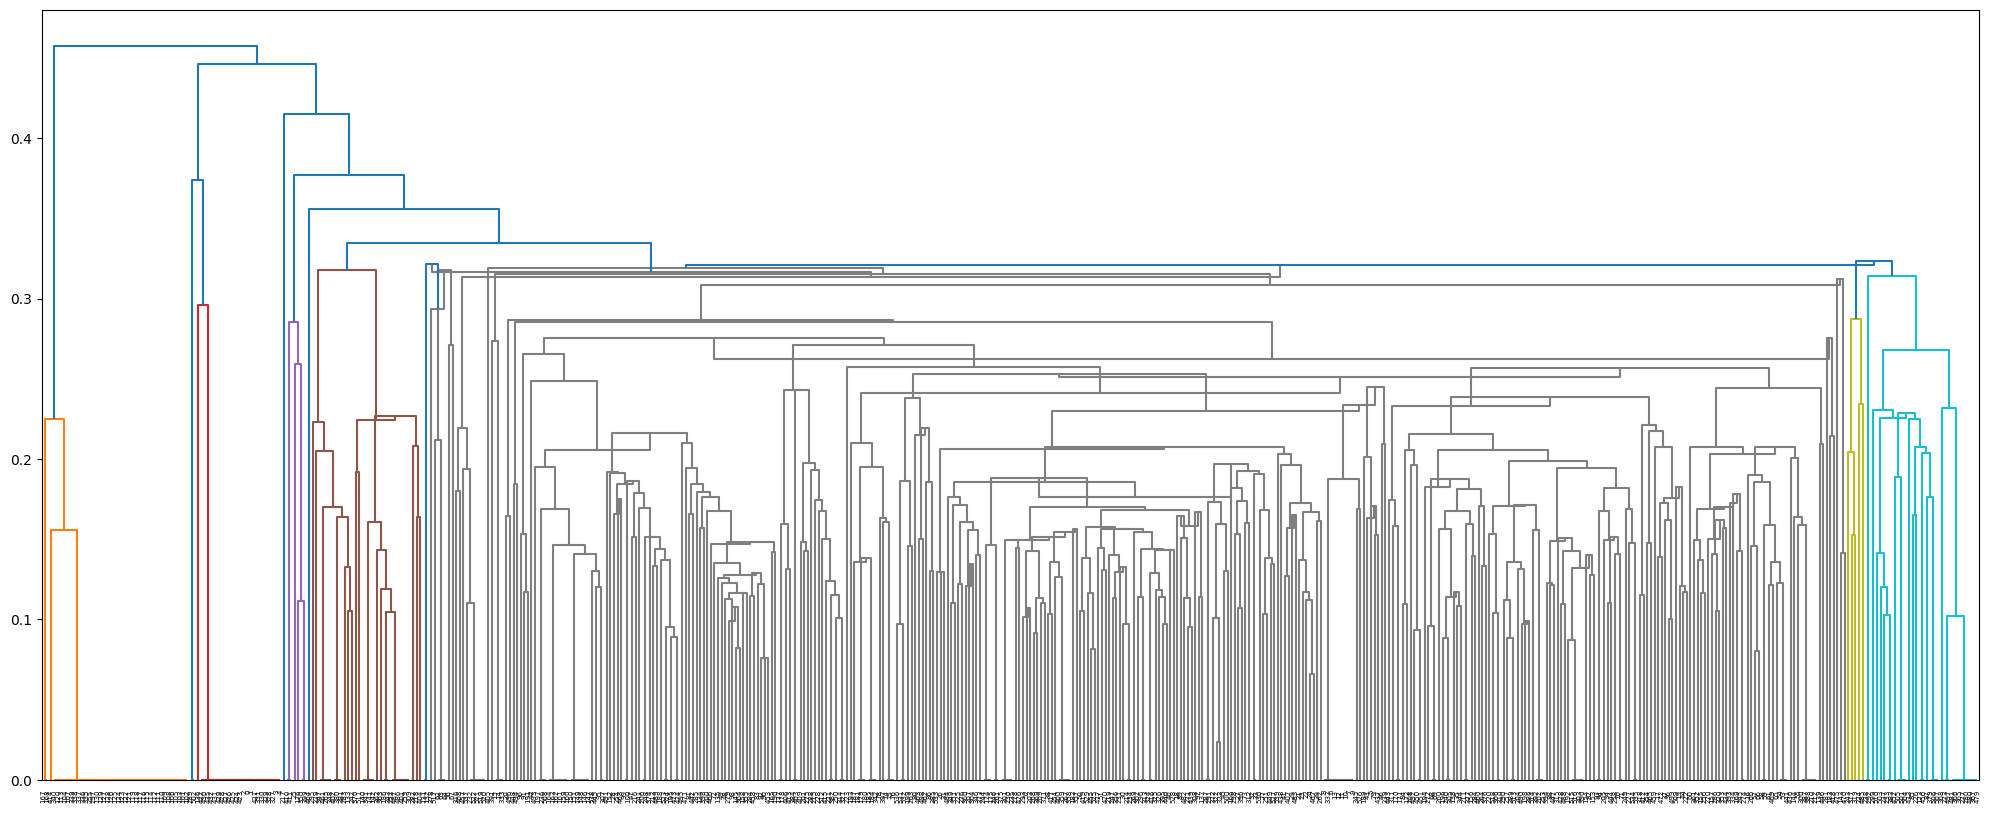

In [101]:
linkage_data = linkage(cluster_embeddings, method='centroid')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_data)
plt.show()

In [102]:
k=40
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(" ".join(dataset_not_padded[j]))
            for word in dataset_not_padded[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
change out blown o-ring on steering pump
change out blown position tyre
change out blown steering hose
change out broken bolt on brake pump
change out broken prelube bracket
change out broken stabilizer bar
change out cracked pipe on valve bank
change out cracked position adaptor and tooth
change out exhaust clamp broken on left hand side [t |]
change out front upper window cracked
change out leak slew motor hose
change out leaking HMU on next
change out leaking fan hoses
change out leaking heater taps
change out leaking hydraulic hose
change out leaking implement pump
change out leaking relay valve
change out leaking steering hose
change out left hand steering cylinder leaking
change out position and tyre worn out
change out position tyre sensor not reading
change out position tyre damage
change out unserviceable jacket water pump
change out unserviceable left hand bucket cylinder hose
change out unserviceable position tyre
change out unserviceable right hand clam cylinder

# maintIE inherent function clusters

#### analysing exceptions with inherent functions 

In [19]:
def analyse_inherent_function_exceptions(row, exception_type=None):

    # list of tuples of head and tail indices
    hasPart_heads = []
    hasPart_tails = []
    contains_heads =[]
    contains_tails =[]
    isA_relations_indices = []

    for r in row["relations"]:
        if r["type"] == "hasPart":
            hasPart_heads.append(r["head"])
            hasPart_tails.append(r["tail"])
        if r["type"] == "contains":
            contains_heads.append(r["head"])
            contains_tails.append(r["tail"])
        if r["type"] == "isA":
            isA_relations_indices.append((r["head"], r["tail"]))

    # remove any repeats
    hasPart_heads = list(set(hasPart_heads))
    hasPart_tails = list(set(hasPart_tails))
    
    # list of physical object indices not in a hasPart or isA relation
    physical_object_indices = []
    
    # get all physical object indices
    for i in range(len(row["entities"])):
        if row["entities"][i]["type"].split("/")[0] == "PhysicalObject":
            physical_object_indices.append(i)
    
    inherent_function_index = []
    for i in hasPart_tails:
        # if tail is not a head of a hasPart relation
        if i not in hasPart_heads:
            inherent_function_index.append(i)
        # remove tail from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)
    
    for i in hasPart_heads:
        # remove head from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)

    for i in isA_relations_indices:
        # remove physical objects that are part of an isA relation
        if i[0] in physical_object_indices:
            physical_object_indices.remove(i[0])
        if i[1] in physical_object_indices:
            physical_object_indices.remove(i[1])

    # EXCEPTION 1: if there are physical objects that are not part of a hasPart or isA relation
    if exception_type == "1":
        if physical_object_indices and inherent_function_index:
            print(row)
            for i in physical_object_indices:
                print(row["entities"][i])
            print()
    # EXCEPTION 2: if there is zero, or more than one physical object and no hasPart relation
    elif exception_type == "2":
        # count how many non substance physical objects there are
        ob = []
        for e in row["entities"]:
            if e["type"].split("/")[0] == "PhysicalObject" and (len(e["type"].split("/")) == 1 or (len(e["type"].split("/"))>1 and e["type"].split("/")[1]  != "Substance")):
                ob.append(e)

        if (len(inherent_function_index) == 0) and len(ob)!=1 and not isA_relations_indices:
            print(row)
            print("Number of non-substance Physical Objects:", len(ob))
            if ob:
                print(ob)
            print()
    # EXCEPTION 3: if there are more than one leftover tail from hasPart relations
    if exception_type == "3":
        if (len(inherent_function_index) > 1):
            print(row)
    # EXCEPTION 4: if the head and tail of an isA relation are not the same type
    if exception_type == "4":
        for i in isA_relations_indices:
            if row["entities"][i[0]]["type"] != row["entities"][i[1]]["type"]:
                print(row)
    return

f = open("../data/gold_release.json", "r")
# returns JSON object as a dictionary
data = json.load(f)
f.close()

except_type = input("Enter exception type: ")
MWO_by_function = {}

for datum in data:
    types = [e["type"].split("/")[0] for e in datum["entities"]]
    if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
        analyse_inherent_function_exceptions(datum, exception_type=except_type)

{'text': '<id> air leak', 'tokens': ['<id>', 'air', 'leak'], 'entities': [{'start': 1, 'end': 2, 'type': 'PhysicalObject/Substance/Gas'}, {'start': 2, 'end': 3, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]}
Number of non-substance Physical Objects: 0

{'text': '<id> auto-greaser leaking oil', 'tokens': ['<id>', 'auto-greaser', 'leaking', 'oil'], 'entities': [{'start': 1, 'end': 2, 'type': 'PhysicalObject/GeneratingObject/LiquidFlowGeneratingObject'}, {'start': 2, 'end': 3, 'type': 'Process/UndesirableProcess'}, {'start': 3, 'end': 4, 'type': 'PhysicalObject/ProtectingObject/WearProtectingObject'}], 'relations': [{'head': 1, 'tail': 2, 'type': 'hasParticipant/hasPatient'}, {'head': 1, 'tail': 0, 'type': 'hasParticipant/hasAgent'}]}
Number of non-substance Physical Objects: 2
[{'start': 1, 'end': 2, 'type': 'PhysicalObject/GeneratingObject/LiquidFlowGeneratingObject'}, {'start': 3, 'end': 4, 'type': 'PhysicalObject/Pro

#### inherent function clustering

In [695]:
def extract_function_from_entity_index(row, index, equipment_dict=None):
    if equipment_dict:
        start = row["entities"][index]["start"]
        end = row["entities"][index]["end"]
        equipment = " ".join([row["tokens"][i] for i in range(start, end)])
        if equipment not in equipment_dict.keys():
            return None
        return equipment_dict[equipment][:-6].lower()
    types = row["entities"][index]["type"].split("/")
    if len(types) > 1:
        return types[1][:-6].lower()
    else:
        return None
    
def get_inherent_function(row, equipment_dict=None):

    # list of tuples of head and tail indices
    hasPart_heads = []
    hasPart_tails = []
    contains_heads =[]
    contains_tails =[]
    isA_relations_indices = []

    for r in row["relations"]:
        if r["type"] == "hasPart":
            hasPart_heads.append(r["head"])
            hasPart_tails.append(r["tail"])
        if r["type"] == "contains":
            contains_heads.append(r["head"])
            contains_tails.append(r["tail"])
        if r["type"] == "isA":
            isA_relations_indices.append((r["head"], r["tail"]))

    # remove any repeats
    hasPart_heads = list(set(hasPart_heads))
    hasPart_tails = list(set(hasPart_tails))
    
    # list of physical object indices not in a hasPart or isA relation
    physical_object_indices = []
    
    # get all physical object indices
    for i in range(len(row["entities"])):
        if row["entities"][i]["type"].split("/")[0] == "PhysicalObject" and (equipment_dict or len(row["entities"][i]["type"].split("/")) == 1 or (row["entities"][i]["type"].split("/")[1]  != "Substance")):
            physical_object_indices.append(i)
    
    inherent_function_index = []
    for i in hasPart_tails:
        # if tail is not a head of a hasPart relation
        if i not in hasPart_heads:
            inherent_function_index.append(i)
        # remove tail from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)
    
    for i in hasPart_heads:
        # remove head from the physical object indices
        if i in physical_object_indices:
            physical_object_indices.remove(i)

    for i in isA_relations_indices:
        # remove physical objects that are part of an isA relation
        if i[0] in physical_object_indices:
            physical_object_indices.remove(i[0])
        if i[1] in physical_object_indices:
            physical_object_indices.remove(i[1])

    # EXCEPTION 1: if there are physical objects that are not part of a hasPart or isA relation, and there is a hasPart relation
    if physical_object_indices and inherent_function_index:
        # in general, ignore additional physical objects 
        if len(inherent_function_index) ==1:
            isA_tails = [i[1] for i in isA_relations_indices]
            # if there is a more specific (head) object in an isA relation
            if inherent_function_index[0] in isA_tails:
                isA_head_index = isA_relations_indices[isA_tails.index(inherent_function_index[0])][0]
                func = extract_function_from_entity_index(row, isA_head_index, equipment_dict)
                return func
            else:
                func = extract_function_from_entity_index(row, inherent_function_index[0], equipment_dict)
                return func


    # EXCEPTION 2: if there is zero or more than one physical object and no hasPart relations
    if (len(inherent_function_index) == 0) and len(physical_object_indices)!=1 and not isA_relations_indices:
        # if there are no physical objects, remove the row
        if len(physical_object_indices) == 0:
            print("remove:",row, "\n")
            return None
        physical_object_not_substance = []
        for i in physical_object_indices:
            start = row["entities"][i]["start"]
            end = row["entities"][i]["end"]
            # if the physical object is not a substance
            if end == len(row["tokens"]) and " ".join(row["tokens"][start:]) != "oil":
                physical_object_not_substance.append(i)
            elif " ".join(row["tokens"][start:end]) != "oil":
                physical_object_not_substance.append(i)

        # if there is only one non-substance physical object, extract its function
        if len(physical_object_not_substance) == 1:
            func = extract_function_from_entity_index(row, physical_object_not_substance[0], equipment_dict)
            return func
        else:
            # !!! CHECK !!!
            # print(row)
            # print("Manually assign inherent function.")
            # print()
            # return "CHECK"
            func = extract_function_from_entity_index(row, physical_object_indices[0], equipment_dict)
            return func
            
                

    # EXCEPTION 3: if there are more than one leftover tail from hasPart relations
    if (len(inherent_function_index) > 1):
        # manually assign inherent function
        if row["text"] == "replace unserviceable transmission screen and magnet":
            return "transforming"
        elif row["text"] == "pump drive box coupling and shaft unserviceable":
            return "driving"
        else:
            return None
            # print(row)
            # raise Exception("Manually assign inherent function in Exception 3.")
    

    # get entities
    if len(inherent_function_index) == 1 and len(physical_object_indices) == 0:
        func = extract_function_from_entity_index(row, inherent_function_index[0], equipment_dict)
        return func
    elif len(inherent_function_index) == 0 and len(physical_object_indices) == 1:
        func = extract_function_from_entity_index(row, physical_object_indices[0], equipment_dict)
        return func
    elif all(i in [x for xs in isA_relations_indices for x in xs] for i in physical_object_indices):
        isA_heads = [i[0] for i in isA_relations_indices]
        isA_tails = [i[1] for i in isA_relations_indices]
        isA_specific_indices = []
        for i in isA_heads:
            if i not in isA_tails:
                isA_specific_indices.append(i)
        if len(isA_specific_indices) == 1:
            func = extract_function_from_entity_index(row, isA_specific_indices[0], equipment_dict)
            return func
        
        else:
            if row["text"] == "<id> park brake alarm fault":
                return "restricting"
            else:
                return None
                # print(row)
                # print("Manually assign inherent function.")
                # return "CHECK"
    elif len(inherent_function_index)>1:
        return None
        # print("SASDKDHAA")
        # return "CHECK"
    else:
        return None
        # print(row)
        # print("Manually assign inherent function.")
        # print()
        # return "CHECK"
    
    # for e in row["entities"]:
    #     entity_type = e["type"].split("/")
    #     if entity_type[0] == "PhysicalObject":
    #         if len(entity_type) > 1 and entity_type[1] not in ["Substance", "Organism"]:
    #             if entity_type[1][:-6].lower() not in functions:
    #                 functions.append(entity_type[1][:-6].lower())
    # functions = ",".join(sorted(functions))
    # return functions

    # # EXCEPTION 4: if the head and tail of an isA relation are not the same type
    # if exception_type == 4:
    #     for i in isA_relations_indices:
    #         if row["entities"][i[0]]["type"] != row["entities"][i[1]]["type"]:
    #             print(row)


def get_gold_dataset():
    f = open("../data/gold_release.json", "r")
    # returns JSON object as a dictionary
    data = json.load(f)
    f.close()

    MWO_by_function = {}
    dataset = []
    labels = []
    class_list = []
    state_equipment_inherentfunction_by_MWO = {}

    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
            inherent_function = get_inherent_function(datum)
            if not inherent_function:
                continue

            tokens = datum["tokens"].copy()

            # remove activity tokens
            if "Activity" in types:
                activity_indices = []
                for e in datum["entities"]:
                    if e["type"].split("/")[0] == "Activity":
                        for i in range(e["start"], e["end"]):
                            activity_indices.append(i)
                activity_indices = sorted(set(activity_indices), reverse=True)
                for i in activity_indices:
                    tokens.pop(i)
                

            tokens = clean_tokens(tokens)
            dataset.append(tokens)
            if inherent_function not in class_list:
                labels.append(len(class_list))
                class_list.append(inherent_function)
            else:
                labels.append(class_list.index(inherent_function))
            
            # add MWO tokens to dictionary with key inherent function
            if inherent_function in MWO_by_function:
                MWO_by_function[inherent_function].append(tokens)
            else:
                MWO_by_function[inherent_function] = [tokens]
            
            # add state, equipment, and inherent function to dictionary with key MWO
            mwo = " ".join(tokens)
            if mwo not in state_equipment_inherentfunction_by_MWO:
                states = []
                equip = []
                for i in range(len(types)):
                    if types[i] in ["State", "Process", "Property"]:
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        states.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                    elif types[i] == "PhysicalObject":
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        equip.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                state_equipment_inherentfunction_by_MWO[mwo]=[states, equip, inherent_function]

    print("Number of Inherent function clusters:", len(MWO_by_function.keys()))
    for i in MWO_by_function.keys():
        print(i, len(MWO_by_function[i]))
        if len(MWO_by_function[i]) == 1:
            print("   ", MWO_by_function[i])
    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO

In [755]:
def create_equipment_dictionary():
    f = open("../data/gold_release.json", "r")
    # returns JSON object as a dictionary
    data = json.load(f)
    f.close()

    
    # exception multiple types for the same equipment
    ignored_equipment = {"auto-lube":"ProtectingObject", "axle":"GuidingObject", "drag":"MatterProcessingObject", "universal joint":"GuidingObject", "adaptor":"InterfacingObject", "batteries":"StoringObject", "carousel":"StoringObject", "window":"RestrictingObject", "shaft":"GuidingObject", "input shaft":"GuidingObject"}
    equipment = ignored_equipment.copy()
    
    for datum in data:
        for e in datum["entities"]:
            entity_type = e["type"].split("/")
            if entity_type[0] == "PhysicalObject" and len(entity_type) > 1 and entity_type[1] not in ["Substance", "Organism"]:
                start = int(e["start"])
                end = int(e["end"])
                equipment_text = " ".join([datum["tokens"][t] for t in range(start, end)])
                
                if equipment_text in ignored_equipment:
                    continue
                if equipment_text not in equipment:
                    equipment[equipment_text] = entity_type[1]
                # elif equipment[equipment_text] != entity_type[1]:
                #     del equipment[equipment_text]
                    # ignored_equipment.append(equipment_text)
                    
                    # print("ERROR: Equipment text has multiple types")
                    # print(equipment_text)
                    # print(equipment[equipment_text])
                    # print(entity_type[1])
                    # print()
    return equipment

def prepare_synthetic_data(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO):
    import csv


    with open("../data/synthetic.csv", 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)
        counter = 0
        for row in csvreader:
            tokens = row[0].split()
            if len(row[1].split("/")) == 1 or row[1].split("/")[1] in ["Substance", "Organism"]:
                counter+=1
                continue
            inherent_function = row[1].split("/")[1][:-6].lower()

            # # remove activity tokens
            # if "Activity" in types:
            #     activity_indices = []
            #     for e in datum["entities"]:
            #         if e["type"].split("/")[0] == "Activity":
            #             for i in range(e["start"], e["end"]):
            #                 activity_indices.append(i)
            #     activity_indices = sorted(set(activity_indices), reverse=True)
            #     for i in activity_indices:
            #         tokens.pop(i)
            
            tokens = clean_tokens(tokens)
            dataset.append(tokens)
            if inherent_function not in class_list:
                labels.append(len(class_list))
                class_list.append(inherent_function)
            else:
                labels.append(class_list.index(inherent_function))
            
            # add MWO tokens to dictionary with key inherent function
            if inherent_function in MWO_by_function:
                MWO_by_function[inherent_function].append(tokens)
            else:
                MWO_by_function[inherent_function] = [tokens]
            
            mwo= " ".join(tokens)
            # add state, equipment, inherent function to dictionary with key tokens
            if mwo not in state_equipment_inherentfunction_by_MWO:
                states = []
                equip = []
                states.append(row[3])
                equip.append(row[2])
                state_equipment_inherentfunction_by_MWO[mwo]=[states, equip, inherent_function]
    
    print("\nNumber of Inherent function clusters:", len(MWO_by_function.keys()))
    for i in MWO_by_function.keys():
        print(i, len(MWO_by_function[i]))
        if len(MWO_by_function[i]) == 1:
            print("   ", MWO_by_function[i])
    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO
            
    




def annotate_silver():
    equipment_dict = create_equipment_dictionary()
    
    f = open("../data/silver_release.json", "r")
    # returns JSON object as a dictionary
    data = json.load(f)
    f.close()

    dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = get_gold_dataset()


    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if ("State" in types or "Process" in types or "Property" in types) and "PhysicalObject" in types:
            inherent_function = get_inherent_function(datum, equipment_dict)
            if not inherent_function:
                continue
            
            tokens = datum["tokens"].copy()

            # remove activity tokens
            if "Activity" in types:
                activity_indices = []
                for e in datum["entities"]:
                    if e["type"].split("/")[0] == "Activity":
                        for i in range(e["start"], e["end"]):
                            activity_indices.append(i)
                activity_indices = sorted(set(activity_indices), reverse=True)
                for i in activity_indices:
                    tokens.pop(i)
            
            tokens = clean_tokens(tokens)
            dataset.append(tokens)
            if inherent_function not in class_list:
                labels.append(len(class_list))
                class_list.append(inherent_function)
            else:
                labels.append(class_list.index(inherent_function))
            
            # add MWO tokens to dictionary with key inherent function
            if inherent_function in MWO_by_function:
                MWO_by_function[inherent_function].append(tokens)
            else:
                MWO_by_function[inherent_function] = [tokens]
            
            mwo= " ".join(tokens)
            # add state, equipment, inherent function to dictionary with key tokens
            if mwo not in state_equipment_inherentfunction_by_MWO:
                states = []
                equip = []
                for i in range(len(types)):
                    if types[i] in ["State", "Process", "Property"]:
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        states.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                    elif types[i] == "PhysicalObject":
                        start = datum["entities"][i]["start"]
                        end = datum["entities"][i]["end"]
                        equip.append(" ".join([datum["tokens"][j] for j in range(start, end)]))
                state_equipment_inherentfunction_by_MWO[mwo]=[states, equip, inherent_function]

    

    print("\nNumber of Inherent function clusters:", len(MWO_by_function.keys()))
    for i in MWO_by_function.keys():
        print(i, len(MWO_by_function[i]))
        if len(MWO_by_function[i]) == 1:
            print("   ", MWO_by_function[i])
    
    # prepare synthetic data
    # dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = prepare_synthetic_data(dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO)

    return dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO

dataset, labels, class_list, MWO_by_function, state_equipment_inherentfunction_by_MWO = annotate_silver()

remove: {'text': '<id> air leak', 'tokens': ['<id>', 'air', 'leak'], 'entities': [{'start': 1, 'end': 2, 'type': 'PhysicalObject/Substance/Gas'}, {'start': 2, 'end': 3, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]} 

remove: {'text': '<id> - air leak', 'tokens': ['<id>', '-', 'air', 'leak'], 'entities': [{'start': 2, 'end': 3, 'type': 'PhysicalObject/Substance/Gas'}, {'start': 3, 'end': 4, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]} 

remove: {'text': '<id> - fuel leak', 'tokens': ['<id>', '-', 'fuel', 'leak'], 'entities': [{'start': 2, 'end': 3, 'type': 'PhysicalObject/Substance/Liquid'}, {'start': 3, 'end': 4, 'type': 'Process/UndesirableProcess'}], 'relations': [{'head': 1, 'tail': 0, 'type': 'hasParticipant/hasPatient'}]} 

remove: {'text': '<id> <id> replace hydraulic oil leak text', 'tokens': ['<id>', '<id>', 'replace', 'hydraulic', 'oil', 

In [756]:
class_list

['sensing',
 'emitting',
 'matterprocessing',
 'presenting',
 'generating',
 'controlling',
 'guiding',
 'driving',
 'transforming',
 'protecting',
 'storing',
 'humaninteraction',
 'holding',
 'covering',
 'interfacing',
 'restricting',
 'informationprocessing']

In [757]:
# # balanced dataset 
# dataset = []
# labels = []
# random.seed(42)
# for i in range(17):
#     if class_list[i] == "informationprocessing": # CHECK INDEX class_list[i]
#         continue
#     dataset += random.sample(MWO_by_function[class_list[i]], min(len(MWO_by_function[class_list[i]]), 108))
#     labels += [i for j in range(min(len(MWO_by_function[class_list[i]]), 108))]


# remove information processing
for i in MWO_by_function["informationprocessing"]:
    if i in dataset:
        print("Removed")
        dataset.remove(i)
labels = [i for i in labels if i != 16] 

Removed
Removed
Removed
Removed
Removed


In [758]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, random_state=42, shuffle=True, test_size=0.2)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [759]:
print("training set length:",len( X_train))
print("test set length:", len(X_test))
print("dataset length:",len( dataset))


training set length: 2024
test set length: 507
dataset length: 2531


In [748]:
def w2v_embed(x, max_len):
    # Word2Vec embeddings as input
    x_copy = x.copy()
    padded_x = pad_sequence(x_copy, max_len)
    w2vmodel = gensim.models.Word2Vec(padded_x, min_count=1, vector_size=100,
                                    window=5, sg=1)
    w2v_embeddings = []
    for sentence in padded_x:
        row = []
        for word in sentence:
            row.append(w2vmodel.wv[word])
        w2v_embeddings.append(row)
    w2v_embeddings = np.array(w2v_embeddings)
    # w2v_embeddings = w2v_embeddings.reshape(w2v_embeddings.shape[0], w2v_embeddings.shape[1], w2v_embeddings.shape[2], 1)

    return w2v_embeddings

max_len = len(max(dataset, key=len))
w2v_embeddings_X_train = w2v_embed(X_train, max_len)
y_train = np.array(y_train)
w2v_embeddings_X_test = w2v_embed(X_test, max_len)
y_test = np.array(y_test)
print(w2v_embeddings_X_train.shape)
print(w2v_embeddings_X_test.shape)

max length of MWO: 10
max length of MWO: 10
(2024, 10, 100)
(507, 10, 100)


In [760]:
# SBERT embeddings
sbert = SentenceTransformer("all-MiniLM-L6-v2")
SBERT_embeddings_train = sbert.encode(X_train)
SBERT_embeddings_test = sbert.encode(X_test)
SBERT_dataset = sbert.encode(X_train + X_test)
# SBERT_embeddings_train = SBERT_embeddings_train.reshape(SBERT_embeddings_train.shape[0], SBERT_embeddings_train.shape[1], 1)
# SBERT_embeddings_test = SBERT_embeddings_test.reshape(SBERT_embeddings_test.shape[0], SBERT_embeddings_test.shape[1], 1)

print(SBERT_embeddings_train.shape)
print(SBERT_embeddings_test.shape)
print(SBERT_dataset.shape)


/opt/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(2024, 384)
(507, 384)
(2531, 384)


In [228]:
def LSI_ebed(x):
    # LSI embeddings as output
    dictionary = gensim.corpora.Dictionary(x)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in x]
    lsamodel = LsiModel(doc_term_matrix, num_topics=10, id2word = dictionary)  # train model
    concepts = list(lsamodel[doc_term_matrix])
    lsa_embeddings=[]
    for i in concepts:
        row = []
        for j in i:
            row.append(j[1])
        lsa_embeddings.append(row)

    for i in range(len(lsa_embeddings)):
        if len(lsa_embeddings[i]) != 10:
            print(x[i])
    lsa_embeddings = np.array(lsa_embeddings)
    return lsa_embeddings



#### w2v -> Inherent Function

In [574]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (2,2), padding="same", input_shape=(10,100,1), use_bias=False),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Activation("relu"),
#     tf.keras.layers.MaxPool2D(pool_size=2),
#     # tf.keras.layers.Conv2D(8, (2,2), padding="same", use_bias=False),
#     # tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Activation("relu"),
#     # tf.keras.layers.MaxPool2D(pool_size=2),
    
#     tf.keras.layers.Flatten(),
#     # tf.keras.layers.Dense(units=128),
#     # tf.keras.layers.Activation("tanh"),
#     tf.keras.layers.Dense(units=10),
#     tf.keras.layers.Activation("tanh"),
#     tf.keras.layers.Dense(units=17, activation="softmax")
# ])
model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(units=64, activation="tanh", input_shape=(10,100,1)),
    tf.keras.layers.Dense(units=32, activation="tanh"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10, activation="tanh"),
    tf.keras.layers.Dense(units=16, activation="softmax")
])
# model = tf.keras.Sequential([
#     # tf.keras.layers.LSTM(64, input_shape=(10,100)),
#     tf.keras.layers.Input(shape=(10,100)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dense(64, activation='relu'), 
#     tf.keras.layers.Dense(units=16, activation="softmax")
# ])
# model.summary()
# dr = 10
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(16, (2, 2), activation='relu', padding="same", input_shape=(10,100,1)),
#     tf.keras.layers.MaxPool2D(pool_size=2),
#     tf.keras.layers.Conv2D(8, (2, 2), activation='relu', padding="same"),
#     tf.keras.layers.MaxPool2D(pool_size=2),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=dr, activation="tanh"),
#     tf.keras.layers.Dense(units=16, activation="softmax")
# ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
class_weight = {}
for i in MWO_by_function.keys():
    class_weight[class_list.index(i)] = len(MWO_by_function[i])/len(dataset)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)
history = model.fit(w2v_embeddings_X_train, y_train, epochs=200, validation_data=(w2v_embeddings_X_test, y_test), callbacks=[early_stopping], class_weight=class_weight)

Epoch 1/200
62/62 [==============================] - 1s 11ms/step - loss: 0.1936 - accuracy: 0.2850 - val_loss: 2.5697 - val_accuracy: 0.1400
Epoch 2/200
62/62 [==============================] - 1s 10ms/step - loss: 0.1669 - accuracy: 0.3327 - val_loss: 2.6791 - val_accuracy: 0.1460
Epoch 3/200
62/62 [==============================] - 1s 8ms/step - loss: 0.1540 - accuracy: 0.3605 - val_loss: 2.8770 - val_accuracy: 0.1460
Epoch 4/200
62/62 [==============================] - 1s 9ms/step - loss: 0.1476 - accuracy: 0.3687 - val_loss: 2.8714 - val_accuracy: 0.1460
Epoch 5/200
62/62 [==============================] - 1s 9ms/step - loss: 0.1424 - accuracy: 0.3737 - val_loss: 2.9430 - val_accuracy: 0.1481
Epoch 6/200
62/62 [==============================] - 1s 9ms/step - loss: 0.1375 - accuracy: 0.3945 - val_loss: 2.9368 - val_accuracy: 0.1460
Epoch 7/200
62/62 [==============================] - 1s 8ms/step - loss: 0.1340 - accuracy: 0.4204 - val_loss: 2.8842 - val_accuracy: 0.1501
Epoch 8/200

In [575]:
pred_train = model.predict(w2v_embeddings_X_train)
pred_train = pred_train.argmax(axis=-1)
print(model.evaluate(w2v_embeddings_X_train, y_train))

print(pred_train[0:100])
print(y_train[0:100])

pred_test = model.predict(w2v_embeddings_X_test)
pred_test = pred_test.argmax(axis=-1)
print(model.evaluate(w2v_embeddings_X_test, y_test))

print(pred_test)
print(y_test)

62/62 [==============================] - 0s 5ms/step - loss: 2.2297 - accuracy: 0.3301
[2.229745388031006, 0.3301216959953308]
[12  6  6  6  6  6 12 12  6  6  6  6 12 12 12 12  1  7 12 12  6 12 12  6
  6  6  6  6  1  1 12  6  6 12 12  1  6  1  6  6 12  6  6  6 12 12 12  6
 12  6  6  6  6  6 12 12  6  1  6  1  6  1  6  1  6  6  6  6  6 12  1 12
  6  1  6  6  1 12 12 12  6  1 12 12  6  1  6  6 12  1  6  6 12 12  6 12
 12  6  6  6]
[ 4  6  6  6  4  7 10  9  0  9  9  4  1 12  3 12 15  7 12 13  8  1  2  9
 13  4  6  8  1  1 12  9  1 13  6  4  8  0  9  6  1  6  4  6  6  6 12  6
 12 10  1  9  9  6  2 13  8  1  7 15  9  4  6  7  4  5  8  6 12 12  7 12
 15  5  0 10  1  1 13 15  5 14  1 12  9  8  4  7 12  1  6  6  4 12  6  6
  7  6  2  5]
16/16 [==============================] - 0s 4ms/step - loss: 2.5697 - accuracy: 0.1400
[2.569669485092163, 0.1399594247341156]
[12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12  6 12 12 12 

#### SBERT -> Inherent Function

In [762]:
sbert_if_model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(units=64, activation="tanh", input_shape=(384,)),
    tf.keras.layers.Dense(units=64, activation="tanh"),
    tf.keras.layers.Dense(units=32, activation="tanh"),

    tf.keras.layers.Dense(units=10, activation="tanh"),
    tf.keras.layers.Dense(units=16, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
class_weight = {}
for i in MWO_by_function.keys():
    class_weight[class_list.index(i)] = len(MWO_by_function[i])/len(dataset)

sbert_if_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)
history = sbert_if_model.fit(SBERT_embeddings_train, y_train, epochs=200, validation_data=(SBERT_embeddings_test, y_test), callbacks=[early_stopping], class_weight=class_weight)

Epoch 1/200
64/64 [==============================] - 2s 10ms/step - loss: 0.2225 - accuracy: 0.2184 - val_loss: 2.5283 - val_accuracy: 0.2367
Epoch 2/200
64/64 [==============================] - 0s 4ms/step - loss: 0.1888 - accuracy: 0.2747 - val_loss: 2.4169 - val_accuracy: 0.2860
Epoch 3/200
64/64 [==============================] - 0s 1ms/step - loss: 0.1686 - accuracy: 0.3498 - val_loss: 2.3395 - val_accuracy: 0.3491
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.1536 - accuracy: 0.4037 - val_loss: 2.2626 - val_accuracy: 0.3728
Epoch 5/200
64/64 [==============================] - 0s 1ms/step - loss: 0.1420 - accuracy: 0.4373 - val_loss: 2.2290 - val_accuracy: 0.3826
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 0.1342 - accuracy: 0.4600 - val_loss: 2.1986 - val_accuracy: 0.3866
Epoch 7/200
64/64 [==============================] - 0s 1ms/step - loss: 0.1277 - accuracy: 0.4763 - val_loss: 2.1688 - val_accuracy: 0.4063
Epoch 8/200


In [763]:
pred_train = sbert_if_model.predict(SBERT_embeddings_train)
pred_train = pred_train.argmax(axis=-1)
print(sbert_if_model.evaluate(SBERT_embeddings_train, y_train))

print(pred_train[0:100])
print(y_train[0:100])

pred_test = sbert_if_model.predict(SBERT_embeddings_test)
pred_test = pred_test.argmax(axis=-1)
print(sbert_if_model.evaluate(SBERT_embeddings_test, y_test))

print(pred_test)
print(y_test)

64/64 [==============================] - 0s 640us/step - loss: 1.4789 - accuracy: 0.6166
[1.4789496660232544, 0.6166008114814758]
[12  6  7 12  4 12  5 12  4  1 12  1  7  6  7  6  6  6  1 12  6  8 12  7
  7  6 15  9 12  6  5  9  1  5  7  6  6  6  9  8  7  6  6  1  2  5  7 12
  9 12  4  5 12  6  9  4  1  1  1  1  9  7  4  9 12  7 12 12  5  5  7  6
 12  7  4  9  6  7  2 12  6  6  6  2  4  5 12 12  1 12  6  8 12  6 12  9
  6 12 12  1]
[12  6  5 12  0  7  5  6  4  1 12  4  7  6  7  6  6  6 10 12  5  8 12  5
  1  5  1  9 12  6  5  9  1  5  8  8  6  2  9  5 11  6  6  6 11 15 10 14
  9 12  4  5  6  6  2  4  1  1  1  7  9  7  3  9 12 13  6 15 15  5  5 14
  9  7  9  9  6  7  2  6  6  6 15 13  8 13  2 12  1  9  6  8 12  6 14  9
  1  2 12  1]
16/16 [==============================] - 0s 719us/step - loss: 2.0651 - accuracy: 0.4832
[2.0650837421417236, 0.483234703540802]
[ 1  8  6 15  7  6  2 12 12  1  2  2  4  1 12  9 12  4  2  8  6  6 12  2
  2  6  1 12  1  9  6  1  8  6  4  8  5 12 12  6  4 12 1

In [764]:
# get hidden layer model 
sbert_if_model_embedding = tf.keras.Sequential([
    
    tf.keras.layers.Dense(units=64, activation="tanh", input_shape=(384,)),
    tf.keras.layers.Dense(units=64, activation="tanh"),
    tf.keras.layers.Dense(units=32, activation="tanh"),

    tf.keras.layers.Dense(units=10, activation="tanh"),
    tf.keras.layers.Dense(units=16, activation="softmax")
])


sbert_if_model_embedding.layers[0].set_weights(sbert_if_model.layers[0].get_weights())
sbert_if_model_embedding.layers[1].set_weights(sbert_if_model.layers[1].get_weights())
sbert_if_model_embedding.layers[2].set_weights(sbert_if_model.layers[2].get_weights())
sbert_if_model_embedding.layers[3].set_weights(sbert_if_model.layers[3].get_weights())
sbert_if_model_embedding.layers[4].set_weights(sbert_if_model.layers[4].get_weights())


SBERT_embeddings = np.concatenate((SBERT_embeddings_train, SBERT_embeddings_test))
cluster_embeddings = sbert_if_model_embedding.predict(SBERT_embeddings)
print(cluster_embeddings.shape)


80/80 [==============================] - 0s 558us/step
(2531, 16)


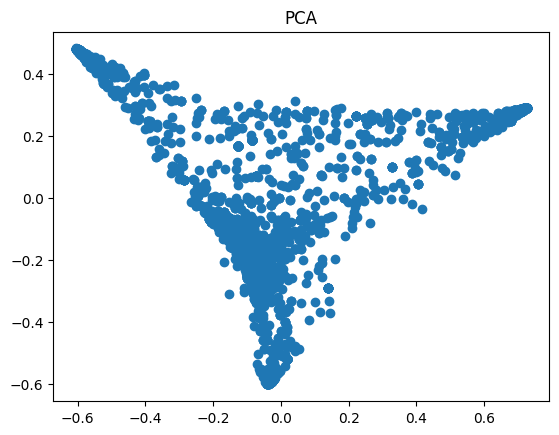

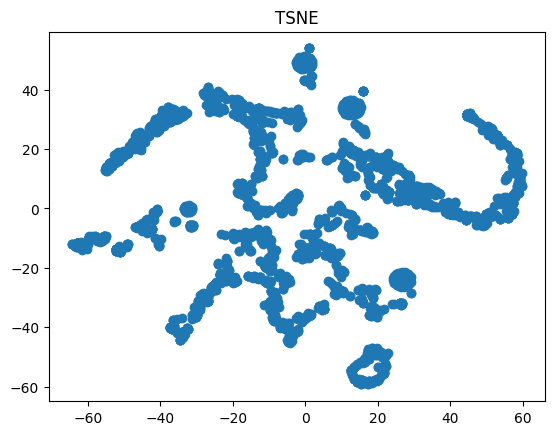

5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100


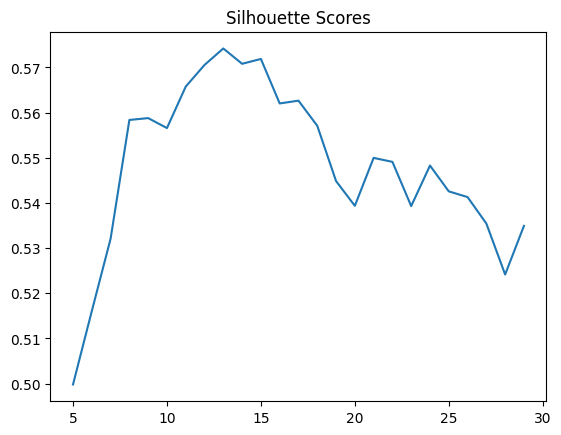

In [765]:

# PCA reduction
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(cluster_embeddings)
plt.scatter(pca_embedding[:,0], pca_embedding[:,1])
plt.title("PCA")
plt.show()

# tsne reduction
tsne = TSNE(n_components=2).fit_transform(cluster_embeddings)
plt.scatter(tsne[:,0], tsne[:,1])
plt.title("TSNE")
plt.show()


# Perform kmean clustering
silhouette_scores = []
test_k = list(range(5, 30))
for i in test_k:
    print(i, "/", 100)
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=100).fit(cluster_embeddings)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(cluster_embeddings, labels))
plt.plot(test_k, silhouette_scores)
plt.title("Silhouette Scores")
plt.show()


In [766]:
# best k
k = 13
kmeans = KMeans(n_clusters=k, random_state=42, n_init=100).fit(cluster_embeddings)
cluster_labels = kmeans.labels_
# dataset_not_padded = full_dataset("../data/gold_release.json")
dataset_x = X_train + X_test

# for i in range(k):
#     print("Cluster ", i)
#     for j in range(len(cluster_labels)):
#         if cluster_labels[j] == i:
#             print(dataset_x[j])
            
#     print()

from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(cluster_labels, y_train.tolist()+y_test.tolist())
print(nmi)


for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    cluster_states={}
    cluster_equip={}
    cluster_inherentfunc={}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            # print(" ".join(dataset[j]))
            for word in dataset[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
            mwo = " ".join(dataset[j])
            state_equip_inherfunc = state_equipment_inherentfunction_by_MWO[mwo]
            for state in state_equip_inherfunc[0]:
                if state in cluster_states:
                    cluster_states[state]+=1
                else:
                    cluster_states[state]=1
            for equip in state_equip_inherfunc[1]:
                if equip in cluster_equip:
                    cluster_equip[equip]+=1
                else:
                    cluster_equip[equip]=1
            if state_equip_inherfunc[2] in cluster_inherentfunc:
                cluster_inherentfunc[state_equip_inherfunc[2]]+=1
            else:
                cluster_inherentfunc[state_equip_inherfunc[2]]=1
    
    # get top words
    print("Cluster Size:", len(cluster_labels[cluster_labels==i]))
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print("  ",sorted_cluster_words[j])
    print()
    sorted_cluster_states = sorted(cluster_states, key=cluster_states.get, reverse=True)
    print("Top states:")
    for j in range(min(len(sorted_cluster_states), 5)):
        print("  ", sorted_cluster_states[j])
    print()

    sorted_cluster_equip = sorted(cluster_equip, key=cluster_equip.get, reverse=True)
    print("Top equipment:")
    for j in range(min(len(sorted_cluster_equip), 5)):
        print("  ", sorted_cluster_equip[j])
    print()

    sorted_cluster_inherentfunc = sorted(cluster_inherentfunc, key=cluster_inherentfunc.get, reverse=True)
    print("Inherent functions in order:")
    for j in range(len(sorted_cluster_inherentfunc)):
        print("  ",sorted_cluster_inherentfunc[j], cluster_inherentfunc[sorted_cluster_inherentfunc[j]])
    print("=========================")

0.38037985191045287
Cluster 1 :
Cluster Size: 120
Top words:
   hand
   unserviceable
   right
   fault
   leak

Top states:
   unserviceable
   leak
   fault
   leaking
   blown

Top equipment:
   light
   hose
   oil
   engine
   brake

Inherent functions in order:
   guiding 20
   holding 16
   emitting 15
   generating 12
   protecting 12
   controlling 10
   driving 6
   storing 5
   covering 5
   restricting 5
   matterprocessing 4
   sensing 3
   interfacing 3
   transforming 2
   presenting 1
   humaninteraction 1
Cluster 2 :
Cluster Size: 296
Top words:
   hand
   leak
   air
   oil
   unserviceable

Top states:
   leak
   unserviceable
   missing
   leaking
   broken

Top equipment:
   oil
   cabin
   air conditioner
   hose
   brake

Inherent functions in order:
   emitting 44
   guiding 41
   holding 40
   protecting 25
   generating 23
   driving 22
   matterprocessing 15
   covering 14
   controlling 14
   transforming 14
   storing 13
   interfacing 11
   restricting 7
 

#### ave hierachical

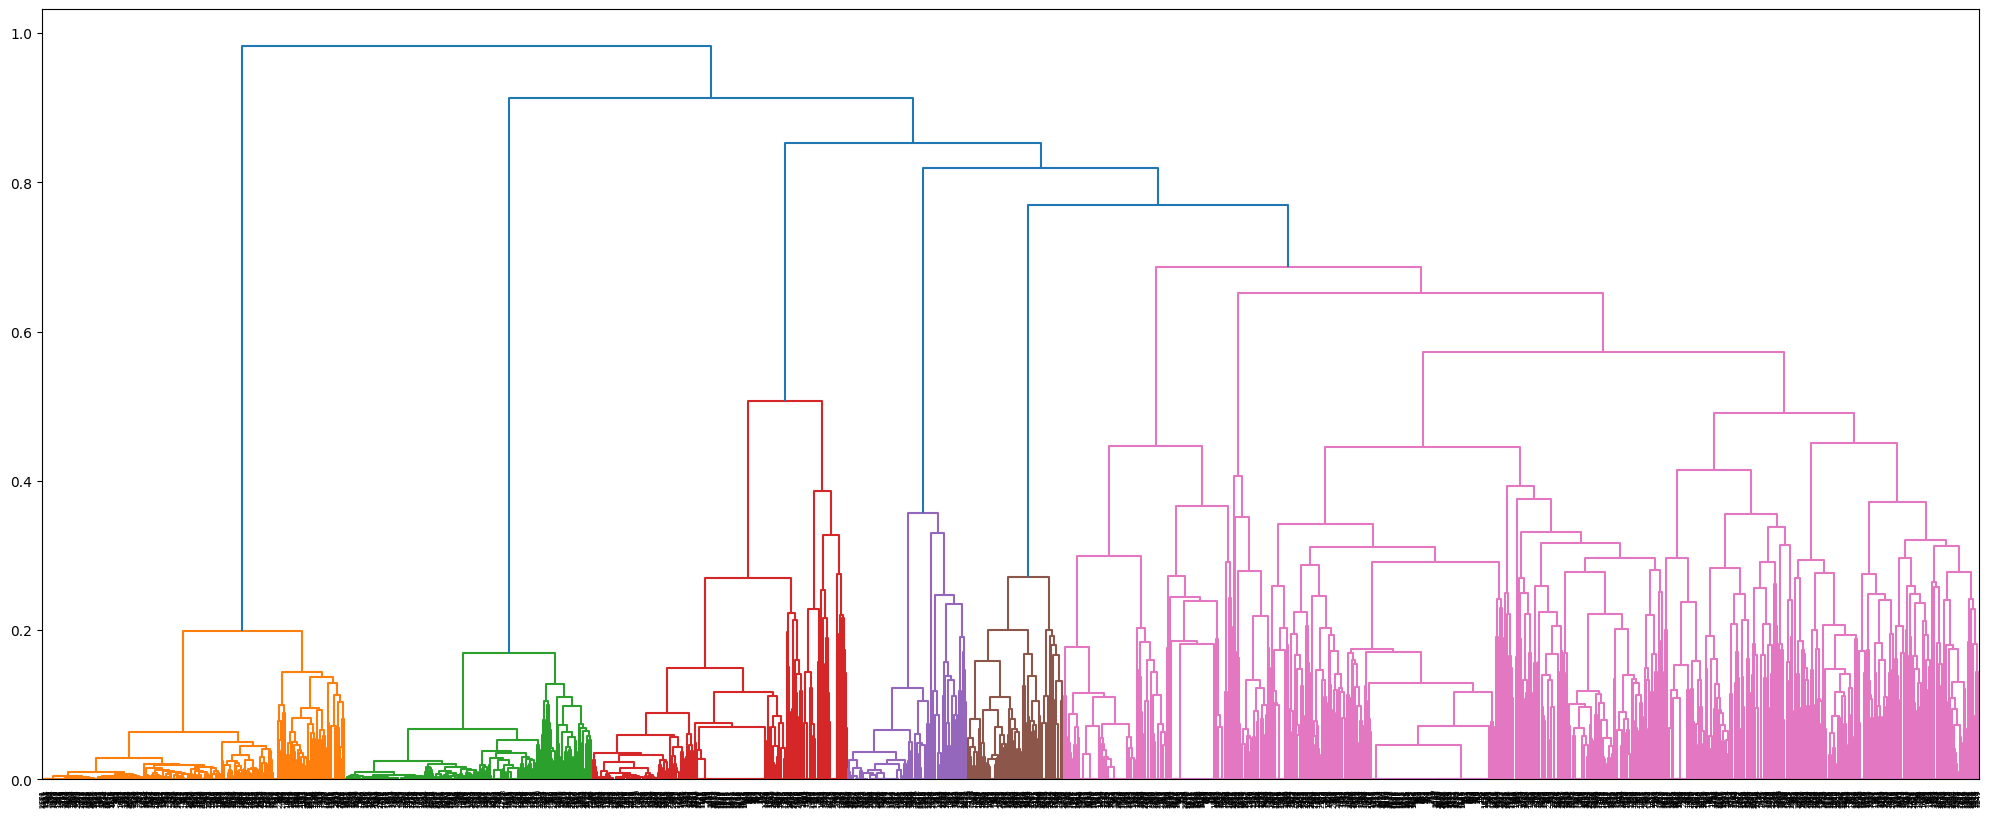

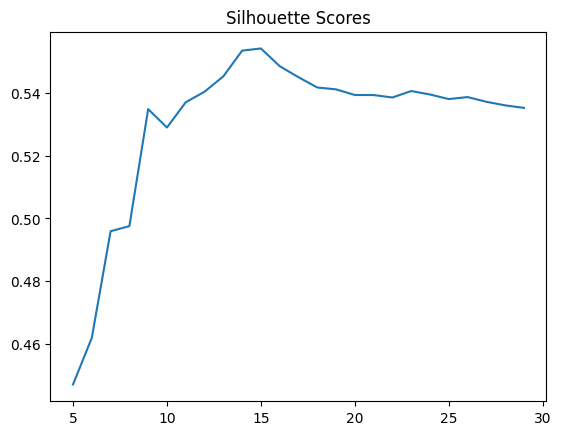

In [771]:
linkage_data = linkage(cluster_embeddings, method='average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_data)
plt.show()

# calculate sihouette score on different k values
silhouette_scores = []
test_k = list(range(5, 30))
for i in test_k:
    cluster_labels = fcluster(linkage_data, i, criterion='maxclust')
    silhouette_scores.append(silhouette_score(cluster_embeddings, cluster_labels))
plt.plot(test_k, silhouette_scores)
plt.title("Silhouette Scores")
plt.show()

In [772]:
k=15
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    cluster_states={}
    cluster_equip={}
    cluster_inherentfunc={}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            # print(" ".join(dataset[j]))
            for word in dataset[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
            mwo = " ".join(dataset[j])
            state_equip_inherfunc = state_equipment_inherentfunction_by_MWO[mwo]
            for state in state_equip_inherfunc[0]:
                if state in cluster_states:
                    cluster_states[state]+=1
                else:
                    cluster_states[state]=1
            for equip in state_equip_inherfunc[1]:
                if equip in cluster_equip:
                    cluster_equip[equip]+=1
                else:
                    cluster_equip[equip]=1
            if state_equip_inherfunc[2] in cluster_inherentfunc:
                cluster_inherentfunc[state_equip_inherfunc[2]]+=1
            else:
                cluster_inherentfunc[state_equip_inherfunc[2]]=1
    
    # get top words
    print("Cluster Size:", len(cluster_labels[cluster_labels==i]))
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print("  ",sorted_cluster_words[j])
    print()
    sorted_cluster_states = sorted(cluster_states, key=cluster_states.get, reverse=True)
    print("Top states:")
    for j in range(min(len(sorted_cluster_states), 5)):
        print("  ", sorted_cluster_states[j])
    print()

    sorted_cluster_equip = sorted(cluster_equip, key=cluster_equip.get, reverse=True)
    print("Top equipment:")
    for j in range(min(len(sorted_cluster_equip), 5)):
        print("  ", sorted_cluster_equip[j])
    print()

    sorted_cluster_inherentfunc = sorted(cluster_inherentfunc, key=cluster_inherentfunc.get, reverse=True)
    print("Inherent functions in order:")
    for j in range(len(sorted_cluster_inherentfunc)):
        print("  ",sorted_cluster_inherentfunc[j], cluster_inherentfunc[sorted_cluster_inherentfunc[j]])
    print("=========================")

Cluster 1 :
Cluster Size: 396
Top words:
   hand
   leak
   oil
   leaking
   unserviceable

Top states:
   leak
   leaking
   unserviceable
   broken
   fault

Top equipment:
   hose
   oil
   air conditioner
   engine
   pump

Inherent functions in order:
   guiding 81
   holding 63
   emitting 41
   driving 35
   generating 29
   protecting 28
   controlling 19
   transforming 17
   covering 15
   matterprocessing 14
   restricting 13
   presenting 12
   sensing 10
   storing 9
   interfacing 7
   humaninteraction 3
Cluster 2 :
Cluster Size: 323
Top words:
   leak
   unserviceable
   hand
   leaking
   oil

Top states:
   leak
   unserviceable
   leaking
   broken
   fault

Top equipment:
   hose
   oil
   engine
   air conditioner
   pump

Inherent functions in order:
   guiding 60
   holding 51
   emitting 37
   driving 24
   generating 23
   protecting 22
   controlling 20
   transforming 19
   covering 16
   matterprocessing 11
   storing 11
   sensing 8
   restricting 7
   inte

In [773]:
k=9
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    cluster_states={}
    cluster_equip={}
    cluster_inherentfunc={}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            # print(" ".join(dataset[j]))
            for word in dataset[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
            mwo = " ".join(dataset[j])
            state_equip_inherfunc = state_equipment_inherentfunction_by_MWO[mwo]
            for state in state_equip_inherfunc[0]:
                if state in cluster_states:
                    cluster_states[state]+=1
                else:
                    cluster_states[state]=1
            for equip in state_equip_inherfunc[1]:
                if equip in cluster_equip:
                    cluster_equip[equip]+=1
                else:
                    cluster_equip[equip]=1
            if state_equip_inherfunc[2] in cluster_inherentfunc:
                cluster_inherentfunc[state_equip_inherfunc[2]]+=1
            else:
                cluster_inherentfunc[state_equip_inherfunc[2]]=1
    
    # get top words
    print("Cluster Size:", len(cluster_labels[cluster_labels==i]))
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print("  ",sorted_cluster_words[j])
    print()
    sorted_cluster_states = sorted(cluster_states, key=cluster_states.get, reverse=True)
    print("Top states:")
    for j in range(min(len(sorted_cluster_states), 5)):
        print("  ", sorted_cluster_states[j])
    print()

    sorted_cluster_equip = sorted(cluster_equip, key=cluster_equip.get, reverse=True)
    print("Top equipment:")
    for j in range(min(len(sorted_cluster_equip), 5)):
        print("  ", sorted_cluster_equip[j])
    print()

    sorted_cluster_inherentfunc = sorted(cluster_inherentfunc, key=cluster_inherentfunc.get, reverse=True)
    print("Inherent functions in order:")
    for j in range(len(sorted_cluster_inherentfunc)):
        print("  ",sorted_cluster_inherentfunc[j], cluster_inherentfunc[sorted_cluster_inherentfunc[j]])
    print("=========================")

Cluster 1 :
Cluster Size: 396
Top words:
   hand
   leak
   oil
   leaking
   unserviceable

Top states:
   leak
   leaking
   unserviceable
   broken
   fault

Top equipment:
   hose
   oil
   air conditioner
   engine
   pump

Inherent functions in order:
   guiding 81
   holding 63
   emitting 41
   driving 35
   generating 29
   protecting 28
   controlling 19
   transforming 17
   covering 15
   matterprocessing 14
   restricting 13
   presenting 12
   sensing 10
   storing 9
   interfacing 7
   humaninteraction 3
Cluster 2 :
Cluster Size: 323
Top words:
   leak
   unserviceable
   hand
   leaking
   oil

Top states:
   leak
   unserviceable
   leaking
   broken
   fault

Top equipment:
   hose
   oil
   engine
   air conditioner
   pump

Inherent functions in order:
   guiding 60
   holding 51
   emitting 37
   driving 24
   generating 23
   protecting 22
   controlling 20
   transforming 19
   covering 16
   matterprocessing 11
   storing 11
   sensing 8
   restricting 7
   inte

#### ward heriarchical

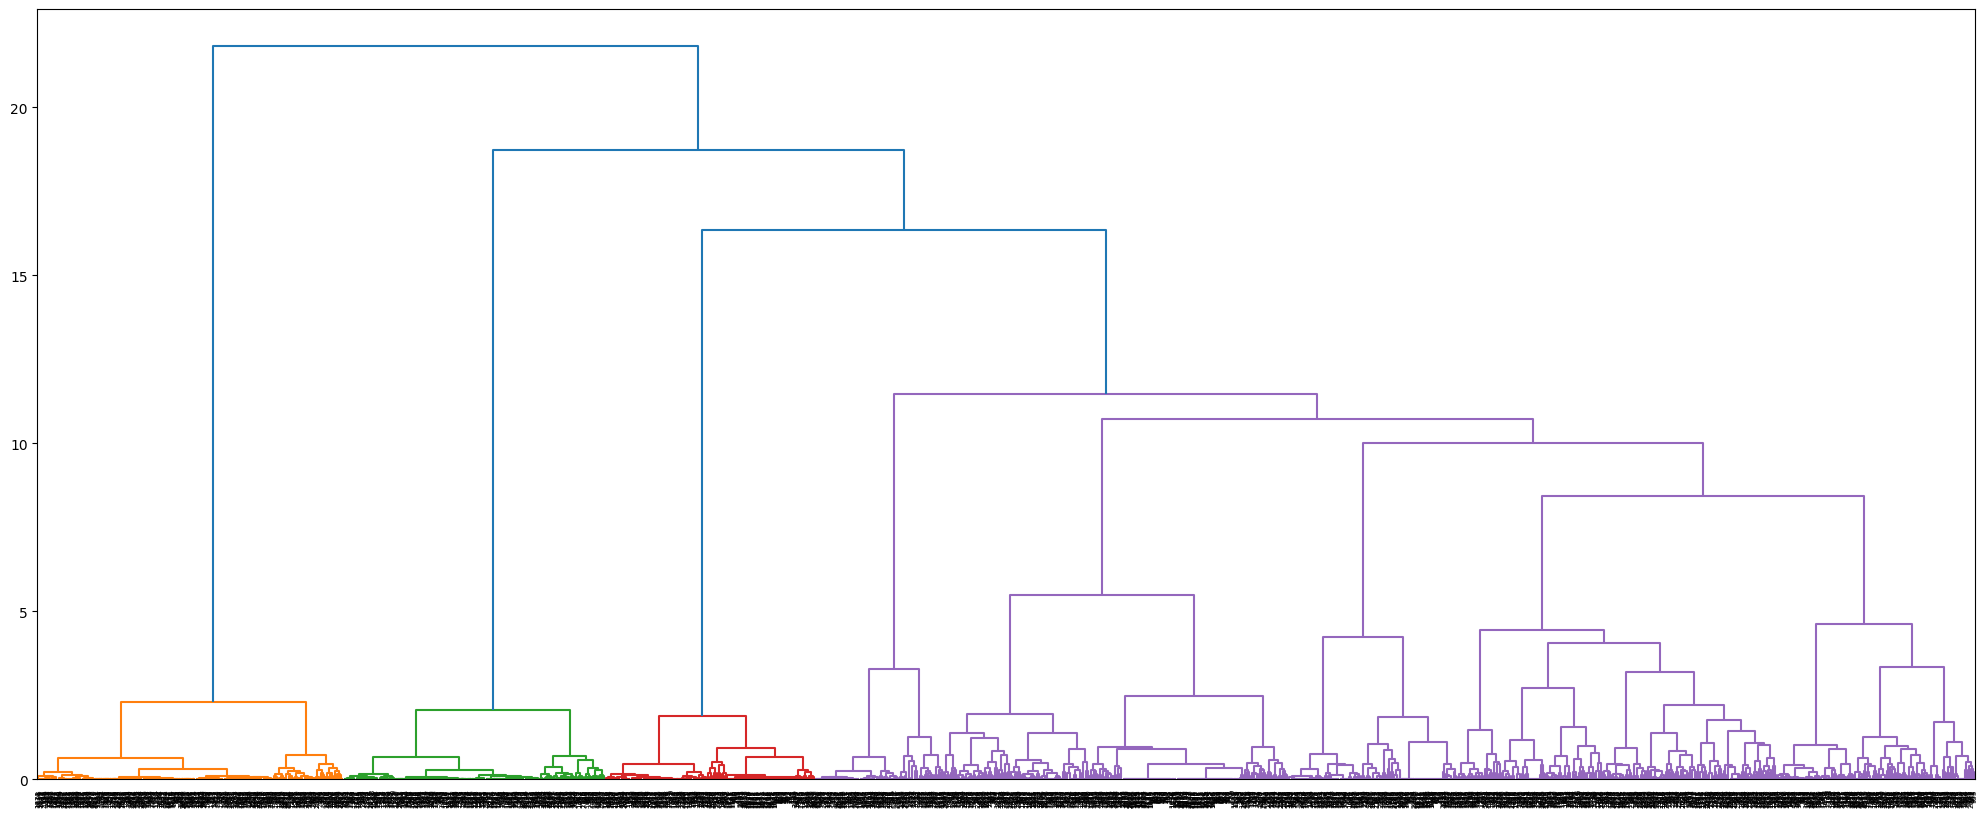

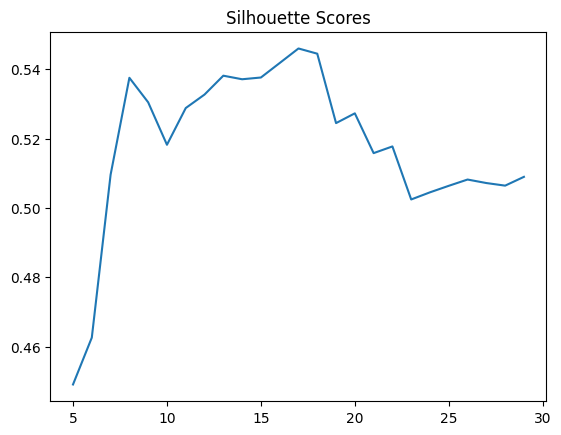

In [774]:
linkage_data = linkage(cluster_embeddings, method='ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_data)
plt.show()

# calculate sihouette score on different k values
silhouette_scores = []
test_k = list(range(5, 30))
for i in test_k:
    cluster_labels = fcluster(linkage_data, i, criterion='maxclust')
    silhouette_scores.append(silhouette_score(cluster_embeddings, cluster_labels))
plt.plot(test_k, silhouette_scores)
plt.title("Silhouette Scores")
plt.show()

In [775]:
k=8
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    cluster_states={}
    cluster_equip={}
    cluster_inherentfunc={}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            # print(" ".join(dataset[j]))
            for word in dataset[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
            mwo = " ".join(dataset[j])
            state_equip_inherfunc = state_equipment_inherentfunction_by_MWO[mwo]
            for state in state_equip_inherfunc[0]:
                if state in cluster_states:
                    cluster_states[state]+=1
                else:
                    cluster_states[state]=1
            for equip in state_equip_inherfunc[1]:
                if equip in cluster_equip:
                    cluster_equip[equip]+=1
                else:
                    cluster_equip[equip]=1
            if state_equip_inherfunc[2] in cluster_inherentfunc:
                cluster_inherentfunc[state_equip_inherfunc[2]]+=1
            else:
                cluster_inherentfunc[state_equip_inherfunc[2]]=1
    
    # get top words
    print("Cluster Size:", len(cluster_labels[cluster_labels==i]))
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print("  ",sorted_cluster_words[j])
    print()
    sorted_cluster_states = sorted(cluster_states, key=cluster_states.get, reverse=True)
    print("Top states:")
    for j in range(min(len(sorted_cluster_states), 5)):
        print("  ", sorted_cluster_states[j])
    print()

    sorted_cluster_equip = sorted(cluster_equip, key=cluster_equip.get, reverse=True)
    print("Top equipment:")
    for j in range(min(len(sorted_cluster_equip), 5)):
        print("  ", sorted_cluster_equip[j])
    print()

    sorted_cluster_inherentfunc = sorted(cluster_inherentfunc, key=cluster_inherentfunc.get, reverse=True)
    print("Inherent functions in order:")
    for j in range(len(sorted_cluster_inherentfunc)):
        print("  ",sorted_cluster_inherentfunc[j], cluster_inherentfunc[sorted_cluster_inherentfunc[j]])
    print("=========================")

Cluster 1 :
Cluster Size: 400
Top words:
   hand
   leak
   leaking
   oil
   unserviceable

Top states:
   leak
   leaking
   unserviceable
   broken
   fault

Top equipment:
   hose
   oil
   air conditioner
   engine
   pump

Inherent functions in order:
   guiding 83
   holding 63
   emitting 41
   driving 35
   generating 29
   protecting 28
   controlling 20
   transforming 17
   covering 15
   matterprocessing 14
   restricting 13
   presenting 12
   sensing 10
   storing 10
   interfacing 7
   humaninteraction 3
Cluster 2 :
Cluster Size: 341
Top words:
   unserviceable
   hand
   leak
   leaking
   broken

Top states:
   unserviceable
   leak
   leaking
   broken
   fault

Top equipment:
   hose
   oil
   engine
   air conditioner
   light

Inherent functions in order:
   guiding 63
   holding 54
   emitting 39
   generating 24
   driving 24
   protecting 24
   controlling 22
   transforming 19
   covering 17
   storing 12
   matterprocessing 11
   restricting 9
   sensing 8
  

In [776]:
k=16
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    cluster_states={}
    cluster_equip={}
    cluster_inherentfunc={}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            # print(" ".join(dataset[j]))
            for word in dataset[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
            mwo = " ".join(dataset[j])
            state_equip_inherfunc = state_equipment_inherentfunction_by_MWO[mwo]
            for state in state_equip_inherfunc[0]:
                if state in cluster_states:
                    cluster_states[state]+=1
                else:
                    cluster_states[state]=1
            for equip in state_equip_inherfunc[1]:
                if equip in cluster_equip:
                    cluster_equip[equip]+=1
                else:
                    cluster_equip[equip]=1
            if state_equip_inherfunc[2] in cluster_inherentfunc:
                cluster_inherentfunc[state_equip_inherfunc[2]]+=1
            else:
                cluster_inherentfunc[state_equip_inherfunc[2]]=1
    
    # get top words
    print("Cluster Size:", len(cluster_labels[cluster_labels==i]))
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print("  ",sorted_cluster_words[j])
    print()
    sorted_cluster_states = sorted(cluster_states, key=cluster_states.get, reverse=True)
    print("Top states:")
    for j in range(min(len(sorted_cluster_states), 5)):
        print("  ", sorted_cluster_states[j])
    print()

    sorted_cluster_equip = sorted(cluster_equip, key=cluster_equip.get, reverse=True)
    print("Top equipment:")
    for j in range(min(len(sorted_cluster_equip), 5)):
        print("  ", sorted_cluster_equip[j])
    print()

    sorted_cluster_inherentfunc = sorted(cluster_inherentfunc, key=cluster_inherentfunc.get, reverse=True)
    print("Inherent functions in order:")
    for j in range(len(sorted_cluster_inherentfunc)):
        print("  ",sorted_cluster_inherentfunc[j], cluster_inherentfunc[sorted_cluster_inherentfunc[j]])
    print("=========================")

Cluster 1 :
Cluster Size: 400
Top words:
   hand
   leak
   leaking
   oil
   unserviceable

Top states:
   leak
   leaking
   unserviceable
   broken
   fault

Top equipment:
   hose
   oil
   air conditioner
   engine
   pump

Inherent functions in order:
   guiding 83
   holding 63
   emitting 41
   driving 35
   generating 29
   protecting 28
   controlling 20
   transforming 17
   covering 15
   matterprocessing 14
   restricting 13
   presenting 12
   sensing 10
   storing 10
   interfacing 7
   humaninteraction 3
Cluster 2 :
Cluster Size: 341
Top words:
   unserviceable
   hand
   leak
   leaking
   broken

Top states:
   unserviceable
   leak
   leaking
   broken
   fault

Top equipment:
   hose
   oil
   engine
   air conditioner
   light

Inherent functions in order:
   guiding 63
   holding 54
   emitting 39
   generating 24
   driving 24
   protecting 24
   controlling 22
   transforming 19
   covering 17
   storing 12
   matterprocessing 11
   restricting 9
   sensing 8
  

#### clustering

In [ ]:
model_embedding = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (2, 2), activation='relu', padding="same", input_shape=(13,100,1)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(8, (2, 2), activation='relu', padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=dr, activation="tanh"),
])

model2.layers[0].set_weights(model.layers[0].get_weights())
model2.layers[2].set_weights(model.layers[2].get_weights())
model2.layers[4].set_weights(model.layers[4].get_weights())



### Sbert

In [186]:
# SBERT embeddings
sbert = SentenceTransformer("all-MiniLM-L6-v2")
SBERT_embeddings_train = sbert.encode(X_train)
SBERT_embeddings_test = sbert.encode(X_test)
print(SBERT_embeddings_train.shape)

/opt/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(128, 384)


In [191]:
dnn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation="relu", input_shape=(384,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=16, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=16, activation="tanh"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=16, activation="softmax")
])

In [192]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
dnn_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)
history = dnn_model.fit(SBERT_embeddings_train, y_train, epochs=100, validation_data=(SBERT_embeddings_test, y_test), callbacks=[early_stopping])

Epoch 1/100
4/4 [==============================] - 1s 43ms/step - loss: 3.1822 - accuracy: 0.0469 - val_loss: 2.7759 - val_accuracy: 0.0312
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 2.7162 - accuracy: 0.1719 - val_loss: 2.7766 - val_accuracy: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 2.4567 - accuracy: 0.2188 - val_loss: 2.7758 - val_accuracy: 0.0000e+00
Epoch 4/100
4/4 [==============================] - 0s 7ms/step - loss: 2.2502 - accuracy: 0.2891 - val_loss: 2.7751 - val_accuracy: 0.0000e+00
Epoch 5/100
4/4 [==============================] - 0s 6ms/step - loss: 2.1283 - accuracy: 0.4141 - val_loss: 2.7751 - val_accuracy: 0.0000e+00
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 2.0097 - accuracy: 0.4531 - val_loss: 2.7744 - val_accuracy: 0.0000e+00
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 1.8890 - accuracy: 0.5156 - val_loss: 2.7735 - val_accuracy: 0.0000e+00
Ep

In [193]:
print(history.history)
pred_train = model.predict(w2v_embeddings_X_train)
pred_train = pred_train.argmax(axis=-1)
print(model.evaluate(w2v_embeddings_X_train, y_train))

print(pred_train)
print(y_train)

{'loss': [3.1821627616882324, 2.7161943912506104, 2.4566521644592285, 2.250150680541992, 2.1282501220703125, 2.009749412536621, 1.8889797925949097, 1.7863292694091797, 1.7071301937103271, 1.7286838293075562, 1.5853047370910645, 1.5305757522583008, 1.493652105331421, 1.4165291786193848, 1.4065124988555908, 1.3642334938049316, 1.3003815412521362, 1.2480967044830322, 1.2252960205078125, 1.17301344871521, 1.1551299095153809, 1.1185572147369385, 1.098466157913208, 1.074789047241211, 0.9897013306617737, 0.9902865886688232, 1.003983974456787, 0.9321732521057129, 0.9278883337974548, 0.8665132522583008, 0.856272280216217, 0.8100553154945374], 'accuracy': [0.046875, 0.171875, 0.21875, 0.2890625, 0.4140625, 0.453125, 0.515625, 0.5390625, 0.59375, 0.578125, 0.6484375, 0.671875, 0.671875, 0.734375, 0.6796875, 0.734375, 0.7734375, 0.7578125, 0.7734375, 0.78125, 0.7890625, 0.796875, 0.8046875, 0.84375, 0.8515625, 0.84375, 0.84375, 0.84375, 0.8203125, 0.8671875, 0.875, 0.8828125], 'val_loss': [2.77586

### cnn w2v LSA

In [262]:
lsa_embeddings_X_test = LSI_ebed(dataset)
X_train, X_test, y_train, y_test = train_test_split(dataset, lsa_embeddings_X_test, random_state=42, shuffle=True, test_size=0.2)
w2v_embeddings_X_train = w2v_embed(X_train)
w2v_embeddings_X_test = w2v_embed(X_test)

max length of MWO: 9
max length of MWO: 9


In [263]:
dr = 10
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (2, 2), activation='relu', padding="same", input_shape=(9,100,1)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(8, (2, 2), activation='relu', padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=dr, activation="tanh"),
    tf.keras.layers.Dense(units=10, activation="tanh")
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

cnn_model.compile(optimizer=opt,
              loss=tf.keras.losses.MeanSquaredLogarithmicError("sum_over_batch_size"),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)

history = cnn_model.fit(w2v_embeddings_X_train, y_train, epochs=200, validation_data=(w2v_embeddings_X_test, y_test), callbacks=[early_stopping])


Epoch 1/200
4/4 [==============================] - 1s 44ms/step - loss: 0.1498 - accuracy: 0.1953 - val_loss: 0.1253 - val_accuracy: 0.1562
Epoch 2/200
4/4 [==============================] - 0s 14ms/step - loss: 0.1386 - accuracy: 0.1641 - val_loss: 0.1164 - val_accuracy: 0.0625
Epoch 3/200
4/4 [==============================] - 0s 8ms/step - loss: 0.1301 - accuracy: 0.0781 - val_loss: 0.1179 - val_accuracy: 0.0938
Epoch 4/200
4/4 [==============================] - 0s 9ms/step - loss: 0.1308 - accuracy: 0.1953 - val_loss: 0.1169 - val_accuracy: 0.1250
Epoch 5/200
4/4 [==============================] - 0s 9ms/step - loss: 0.1291 - accuracy: 0.1953 - val_loss: 0.1146 - val_accuracy: 0.1250
Epoch 6/200
4/4 [==============================] - 0s 9ms/step - loss: 0.1291 - accuracy: 0.1953 - val_loss: 0.1140 - val_accuracy: 0.1250
Epoch 7/200
4/4 [==============================] - 0s 11ms/step - loss: 0.1290 - accuracy: 0.1953 - val_loss: 0.1138 - val_accuracy: 0.1250
Epoch 8/200
4/4 [=======

In [264]:
pred_train = cnn_model.predict(w2v_embeddings_X_train)
print(cnn_model.evaluate(w2v_embeddings_X_train, y_train))
print(cnn_model.evaluate(w2v_embeddings_X_test, y_test))

print(pred_train[0])
print(y_train[0])

4/4 [==============================] - 0s 2ms/step - loss: 0.1122 - accuracy: 0.3047
[0.11224724352359772, 0.3046875]
1/1 [==============================] - 0s 13ms/step - loss: 0.1075 - accuracy: 0.1250
[0.10753166675567627, 0.125]
[ 0.2729801  -0.32353553 -0.1861186   0.23202688 -0.31970528  0.09729026
  0.09758251  0.31919488  0.2819055   0.14479837]
[ 0.00688159 -0.06182593  0.32433874  0.09975192  0.01193748 -0.09656224
  0.7382632   0.1584699   0.16000169 -0.26760458]


#### clustering

In [268]:
cnn_model_embedding = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (2, 2), activation='relu', padding="same", input_shape=(9,100,1)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(8, (2, 2), activation='relu', padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=dr, activation="tanh"),
])

cnn_model_embedding.layers[0].set_weights(cnn_model.layers[0].get_weights())
cnn_model_embedding.layers[2].set_weights(cnn_model.layers[2].get_weights())
cnn_model_embedding.layers[4].set_weights(cnn_model.layers[4].get_weights())


w2v_embeddings = np.concatenate((w2v_embeddings_X_train, w2v_embeddings_X_test))
cluster_embeddings = cnn_model_embedding.predict(w2v_embeddings)
print(cluster_embeddings.shape)


5/5 [==============================] - 0s 2ms/step
(160, 10)


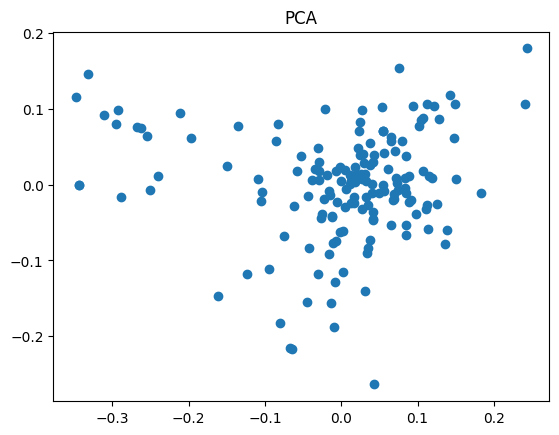

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


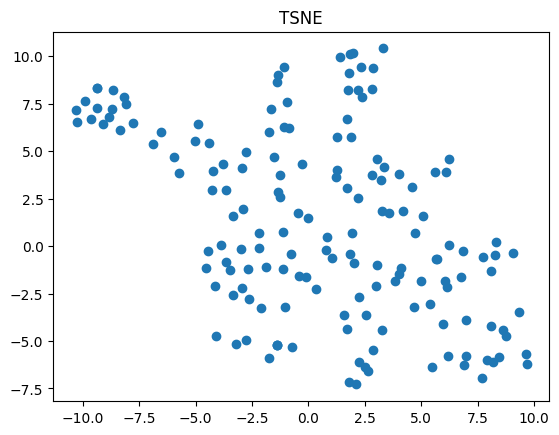

5 / 100
10 / 100
15 / 100
20 / 100
25 / 100
30 / 100
35 / 100
40 / 100
45 / 100
50 / 100
55 / 100
60 / 100
65 / 100
70 / 100
75 / 100
80 / 100
85 / 100
90 / 100
95 / 100
100 / 100


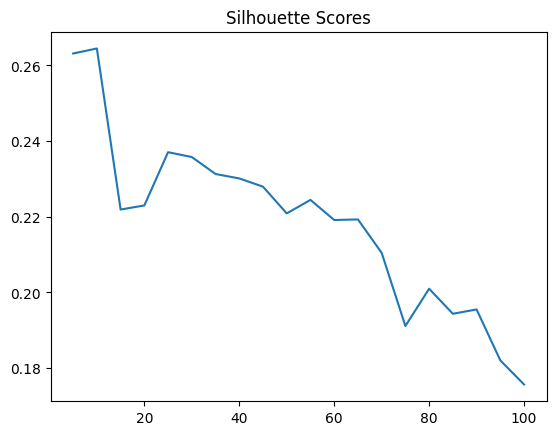

In [269]:
dataset_not_padded = full_dataset("../data/gold_release.json")

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score


# PCA reduction
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(cluster_embeddings)
plt.scatter(pca_embedding[:,0], pca_embedding[:,1])
plt.title("PCA")
plt.show()

# tsne reduction
tsne = TSNE(n_components=2).fit_transform(cluster_embeddings)
plt.scatter(tsne[:,0], tsne[:,1])
plt.title("TSNE")
plt.show()


# Perform kmean clustering
silhouette_scores = []
test_k = list(range(5, 105, 5))
for i in test_k:
    print(i, "/", 100)
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=100).fit(cluster_embeddings)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(cluster_embeddings, labels))
plt.plot(test_k, silhouette_scores)
plt.title("Silhouette Scores")
plt.show()


In [352]:
# best k
k = 25
kmeans = KMeans(n_clusters=k, random_state=42, n_init=100).fit(cluster_embeddings)
cluster_labels = kmeans.labels_

for i in range(k):
    print("Cluster ", i)
    for j in range(len(cluster_labels)):
        if cluster_labels[j] == i:
            print(dataset_not_padded[j])
            
    print()

Cluster  0
['alternator', 'drive', 'leaking']
['alternator', 'overcharge', 'fault']
['backlights', 'on', 'dash', 'blown']
['blown', 'brake', 'hose']
['blown', 'position', 'tyre']
['blown', 'steering', 'hose']
['blown', 'steering', 'pump', 'hose']
['boarding', 'gate', 'latch', 'not', 'working']
['boarding', 'ladder', 'not', 'working']
['change', 'out', 'blown', 'o-ring', 'on', 'steering', 'pump']
['change', 'out', 'broken', 'bolt', 'on', 'brake', 'pump']
['change', 'out', 'unserviceable', 'left', 'hand', 'bucket', 'cylinder', 'hose']
['change', 'out', 'unserviceable', 'position', 'tyre']
['chord', 'pressure', 'fault']

Cluster  1
['air', 'horn', 'stuck', 'on']
['air', 'leak']
['backhoe', 'windscreen', 'to', 'be', 'fixed']
['battery', 'cover', 'hinges', 'seized']
['blade', 'wear', 'plates', 'cracked', 'worn']
['blown', 'air', 'conditioner', 'hose']
['blown', 'oil', 'cooler', 'hose', 'x', 'metre']
['change', 'out', 'leaking', 'HMU', 'on', 'next']

Cluster  2
['air', 'conditioner', 'thermo

In [355]:
from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(cluster_labels, labels)
print(nmi)

0.37128471665791263
